In [1]:
%load_ext autoreload
%autoreload 2

import importlib

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import seirsplus

from seirsplus.viral_model import ViralExtSEIRNetworkModel, VL_PARAMS
from seirsplus.sim_loops_pooled_test import SimulationRunner

import warnings
warnings.filterwarnings('ignore')

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## correlated pooling

In [3]:
import copy

from seirsplus.networks import generate_demographic_contact_network, household_country_data

def generate_population(
    N, country, edge_weight, seed, distancing_scale
):

    random.seed(seed)
    np.random.seed(seed)

    demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                                N=N, demographic_data=household_country_data(country), 
                                                                distancing_scales=[distancing_scale], isolation_groups=[])
    # G = demographic_graphs['baseline']
    G = demographic_graphs[f'distancingScale{distancing_scale}']
    G_weighted = copy.deepcopy(G)
    for e in G.edges():
        if "weight" not in G[e[0]][e[1]]:
            G[e[0]][e[1]]["weight"] = edge_weight
    for e in G_weighted.edges():
        if "weight" not in G_weighted[e[0]][e[1]]:
            G_weighted[e[0]][e[1]]["weight"] = 10**10

    households_dict = {}
    for household in households:
        for node_id in household["indices"]:
            households_dict[node_id] = household["indices"]
    
    return G, G_weighted, households_dict

Generated overall age distribution:
0-9: 0.1144	(-0.0066 from target)
10-19: 0.1226	(-0.0084 from target)
20-29: 0.1378	(0.0008 from target)
30-39: 0.1366	(0.0036 from target)
40-49: 0.1230	(-0.0010 from target)
50-59: 0.1306	(-0.0004 from target)
60-69: 0.1140	(-0.0010 from target)
70-79: 0.0756	(0.0056 from target)
80+: 0.0454	(0.0074 from target)

Generated household size distribution:
1: 0.3022	(0.0185 from target)
2: 0.3378	(-0.0073 from target)
3: 0.1441	(-0.0066 from target)
4: 0.1239	(-0.0038 from target)
5: 0.0598	(0.0020 from target)
6: 0.0207	(-0.0019 from target)
7: 0.0116	(-0.0009 from target)
Num households: 2075
mean household size: 2.448393594

{'0-9': 572, '10-19': 613, '20-29': 689, '30-39': 683, '40-49': 615, '50-59': 653, '60-69': 570, '70-79': 378, '80+': 227}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Text(0.5, 1.0, 'Degree distribution')

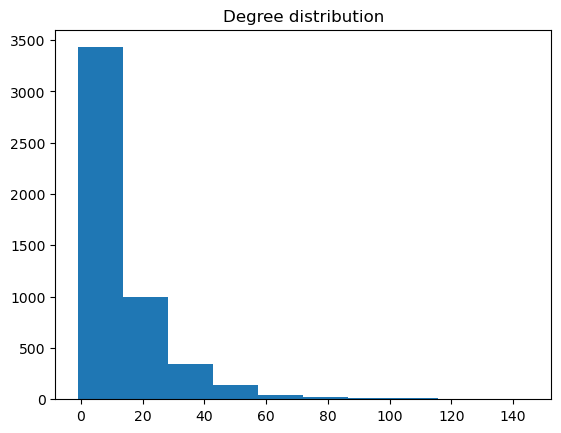

In [5]:
# run this if you want to see the degree distribution
G, G_weighted, households_dict = generate_population(5000, "US", 10, 0)
plt.hist([G.degree[i]-1 for i in range(5000)])
plt.title("Degree distribution") # centered at 10+1000*0.01=20, as expected

In [12]:
demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=5000, demographic_data=household_country_data("US"), 
                                                            distancing_scales=[100, 50, 1, 0.7], isolation_groups=[])

Generated overall age distribution:
0-9: 0.1146	(-0.0064 from target)
10-19: 0.1316	(0.0006 from target)
20-29: 0.1430	(0.0060 from target)
30-39: 0.1314	(-0.0016 from target)
40-49: 0.1182	(-0.0058 from target)
50-59: 0.1280	(-0.0030 from target)
60-69: 0.1168	(0.0018 from target)
70-79: 0.0730	(0.0030 from target)
80+: 0.0434	(0.0054 from target)

Generated household size distribution:
1: 0.2871	(0.0034 from target)
2: 0.3368	(-0.0083 from target)
3: 0.1490	(-0.0017 from target)
4: 0.1367	(0.0090 from target)
5: 0.0541	(-0.0037 from target)
6: 0.0211	(-0.0015 from target)
7: 0.0152	(0.0028 from target)
Num households: 2034
mean household size: 2.448393594

{'0-9': 573, '10-19': 658, '20-29': 715, '30-39': 657, '40-49': 591, '50-59': 640, '60-69': 584, '70-79': 365, '80+': 217}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


In [15]:
demographic_graphs.keys()

dict_keys(['baseline', 'distancingScale0.7'])

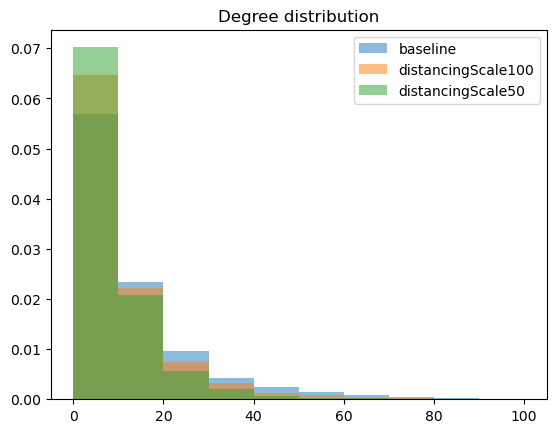

In [13]:
bins = np.linspace(0, 100, 11)

# for k in demographic_graphs.keys():
for k in ["baseline", "distancingScale100", "distancingScale50"]:
    plt.hist([demographic_graphs[k].degree[i]-1 for i in range(5000)], alpha=0.5, label=k, density=True, bins=bins)
plt.title("Degree distribution") # centered at 10+1000*0.01=20, as expected
plt.legend()

In [4]:
def run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T,
    pooling_strategy,
    NUM_SCREENING_GROUPS,
    POOL_SIZE,
    LoD,
    peak_VL,
    dilute,
    seed=0,
    COMMUNITY_SIZE=None
):

    VL_params = copy.deepcopy(VL_PARAMS)
    # NOTE: below parameters are outdated
    for key in ["symptomatic", "asymptomatic"]:
        VL_params[key].update(
            {
                "peak_height": (peak_VL, peak_VL), 
                "start_peak": (3,5),
                "dt_peak": (1,1)
            }
        )

    
    test_model = ViralExtSEIRNetworkModel(
        G = G,
        G_weighted = G_weighted,
        households_dict=households_dict,
        VL_params=VL_params,
        beta = 0.1,
        beta_Q = 0,
        sigma = 0.2,
        lamda = 0.5,
        gamma  = 0.25,
        seed = seed,
        alpha = ALPHA,
        transition_mode="time_in_state",
        initE = N*INIT_PREV//2,
        initI_pre = N*INIT_PREV//2,
        # initI_pre = N*INIT_PREV,
        verbose=1
    )
    sim = SimulationRunner(
        model=test_model,
        pooling_strategy=pooling_strategy,
        T = T,
        # num_groups = 10,
        num_groups = NUM_SCREENING_GROUPS,
        pool_size = POOL_SIZE,
        community_size=COMMUNITY_SIZE,
        LoD=LoD,
        seed = seed,
        save_results=False,
        verbose=2,
        max_dt=0.01,
        dilute=dilute
    )
    sim.run_simulation()

    return sim

In [5]:
def run_sim_final(
    N,
    country,
    edge_weight,
    ALPHA,
    INIT_PREV,
    T,
    pooling_strategy,
    NUM_SCREENING_GROUPS,
    POOL_SIZE,
    LoD,
    peak_VL,
    distancing_scale,
    dilute,
    seed,
    COMMUNITY_SIZE = None
):

    G, G_weighted, households_dict = generate_population(N, country, edge_weight, seed, distancing_scale)

    sim = run_sim(
        G,
        G_weighted,
        households_dict,
        ALPHA,
        N,
        INIT_PREV,
        T=T,
        pooling_strategy=pooling_strategy,
        NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
        POOL_SIZE=POOL_SIZE,
        COMMUNITY_SIZE=COMMUNITY_SIZE,
        LoD=LoD,
        peak_VL=peak_VL,
        dilute=dilute,
        seed=seed,
    )

    return sim

def plot_results(sim, pooling_strategy):

    fig, axs = plt.subplots(1, 5, figsize=(25, 3))

    # ps_label = "CP" if pooling_strategy == "correlated" else "NP"
    ps_label_dict = {
        "correlated": "CP",
        "naive": "NP",
        "correlated_weak": "CP_weak"
    }
    ps_label = ps_label_dict[pooling_strategy]

    axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
    axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
    axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
    axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
    axs[0].legend()
    axs[0].set_title(f"{ps_label} Infection counts")

    axs[2].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean pos", color="tab:blue")
    axs[2].plot([sim.overall_results[i]["mean_num_identifiable_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean id-able pos", color="tab:orange")
    # axs[2].plot([sim.overall_results[i]["median_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "--^", label="median positives", color="tab:blue")
    axs[2].plot([sim.overall_results[i]["median_num_identifiable_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "--^", label="med id-able pos", color="tab:orange")
    axs[2].set_title("Number of positives in positive pools")
    axs[2].legend()

    axs[1].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
    axs[1].set_title("Cumulative test consumption")

    axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
    axs[3].set_title(f"{ps_label} Daily test sensitivity")
    axs[3].set_ylim([0, 1])

    # axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
    # axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
    # axs[4].legend()
    # axs[4].set_title(f"{ps_label} # susceptible neighbors")

    axs[4].set_title(f"{ps_label} Secondary infections")

    bins = np.linspace(0, max(max(sim.model.sec_infs_household.values(), default=0), max(sim.model.sec_infs_non_household.values(), default=0)), 11)
    axs[4].hist(sim.model.sec_infs_household.values(), alpha=0.5, label="sec infs household", bins=bins)
    axs[4].hist(sim.model.sec_infs_non_household.values(), alpha=0.5, label="sec infs non-household", bins=bins)
    axs[4].legend()

    return fig

In [7]:
# nature parameters
WEIGHT = 10
LoD=1240
ALPHA=2
# also VL parameters

# epidemic control 
POOL_SIZE=5
COMMUNITY_SIZE=20
NUM_SCREENING_GROUPS = 3

PEAK_VL = 6.0

INIT_PREV=0.01
N=10000

SEED=24

T = 50

distancing_scale = 50 # try 1 or 0.7 next

DILUTE = "sum"

In [9]:
importlib.reload(seirsplus)

# cp_sim = run_sim_final(
#     N,
#     "US",
#     WEIGHT,
#     ALPHA,
#     INIT_PREV,
#     T=T,
#     pooling_strategy='correlated',
#     NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
#     POOL_SIZE=POOL_SIZE,
#     LoD=LoD,
#     peak_VL=PEAK_VL,
#     distancing_scale=distancing_scale,
#     seed=SEED,
#     dilute=DILUTE
# )

np_sim = run_sim_final(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    distancing_scale=distancing_scale,
    seed=SEED,
    dilute=DILUTE
)


Generated overall age distribution:
0-9: 0.1072	(-0.0138 from target)
10-19: 0.1156	(-0.0154 from target)
20-29: 0.1437	(0.0067 from target)
30-39: 0.1370	(0.0040 from target)
40-49: 0.1259	(0.0019 from target)
50-59: 0.1318	(0.0008 from target)
60-69: 0.1261	(0.0111 from target)
70-79: 0.0731	(0.0031 from target)
80+: 0.0396	(0.0016 from target)

Generated household size distribution:
1: 0.2826	(-0.0011 from target)
2: 0.3461	(0.0010 from target)
3: 0.1473	(-0.0034 from target)
4: 0.1365	(0.0089 from target)
5: 0.0502	(-0.0075 from target)
6: 0.0238	(0.0012 from target)
7: 0.0135	(0.0010 from target)
Num households: 4080
mean household size: 2.448393594

{'0-9': 1072, '10-19': 1156, '20-29': 1437, '30-39': 1370, '40-49': 1259, '50-59': 1318, '60-69': 1261, '70-79': 731, '80+': 396}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


Running simulation with seed 24 for strategy naive...
    Nodes with transition propensities:
        node3190, in state [1], propensity [('StoE', 0.4166666666666667)]
infected: 3190, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {203, 1284, 3191}, non_household_neighbors: [3906, 2307, 4421, 2438, 2950, 3080, 2635, 2641, 2452, 3070, 3033, 3042, 2340, 4717, 2481, 2484, 2421, 2558]
Household member states: [array([3]), array([1]), array([1])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1])]
Infected node 3190 got contribution from infectious contacts {203: 1.0} and quarantined contacts {}
{'t': 0.006440854783802127, 'transitionNode': 3190, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.4166666666666667, sum of all propensities: 65.62536207535888
R

In [10]:
importlib.reload(seirsplus)

cp_weak_sim = run_sim_final(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='correlated_weak',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    COMMUNITY_SIZE=COMMUNITY_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    distancing_scale=distancing_scale,
    seed=SEED,
    dilute=DILUTE
)


Generated overall age distribution:
0-9: 0.1072	(-0.0138 from target)
10-19: 0.1156	(-0.0154 from target)
20-29: 0.1437	(0.0067 from target)
30-39: 0.1370	(0.0040 from target)
40-49: 0.1259	(0.0019 from target)
50-59: 0.1318	(0.0008 from target)
60-69: 0.1261	(0.0111 from target)
70-79: 0.0731	(0.0031 from target)
80+: 0.0396	(0.0016 from target)

Generated household size distribution:
1: 0.2826	(-0.0011 from target)
2: 0.3461	(0.0010 from target)
3: 0.1473	(-0.0034 from target)
4: 0.1365	(0.0089 from target)
5: 0.0502	(-0.0075 from target)
6: 0.0238	(0.0012 from target)
7: 0.0135	(0.0010 from target)
Num households: 4080
mean household size: 2.448393594

{'0-9': 1072, '10-19': 1156, '20-29': 1437, '30-39': 1370, '40-49': 1259, '50-59': 1318, '60-69': 1261, '70-79': 731, '80+': 396}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


Running simulation with seed 24 for strategy correlated_weak...
    Nodes with transition propensities:
        node3190, in state [1], propensity [('StoE', 0.4166666666666667)]
infected: 3190, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {203, 1284, 3191}, non_household_neighbors: [3906, 2307, 4421, 2438, 2950, 3080, 2635, 2641, 2452, 3070, 3033, 3042, 2340, 4717, 2481, 2484, 2421, 2558]
Household member states: [array([3]), array([1]), array([1])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1])]
Infected node 3190 got contribution from infectious contacts {203: 1.0} and quarantined contacts {}
{'t': 0.006440854783802127, 'transitionNode': 3190, 'transitionNodeVL': 0.0, 'transitionType': 'StoE'}
propensity: 0.4166666666666667, sum of all propensities: 65.625362

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Viral loads in positive pools:  [[(203, -1.0, 3.0)], [(471, 0.0, 0.02)], [(2026, -1.0, 3.0)], [(530, -1.0, 3.01)], [(2570, -1.0, 3.01)], [(9513, 0.0, 0.02)], [(915, -1.0, 3.01)], [(4998, -1.0, 3.01)], [(1623, 0.0, 0.02)], [(6335, 0.0, 0.02)], [(7793, -1.0, 3.01)], [(8025, -1.0, 3.01)], [(1726, -1.0, 3.01)], [(9343, -1.0, 3.0)], [(1516, -1.0, 3.0)], [(8237, 0.0, 0.02)], [(1903, -1.0, 3.0)], [(6270, -1.0, 3.01)], [(7947, -1.0, 3.01)], [(7774, 0.0, 0.02)], [(6422, -1.0, 3.0)], [(3026, 0.0, 0.02)], [(8019, 0.0, 0.02)], [(7814, -1.0, 3.01)], [(9460, -1.0, 3.01)], [(2240, 0.0, 0.02)], [(1267, 0.0, 0.02)], [(1421, 0.0, 0.02)], [(8206, -1.0, 3.0)]]
Screening day:  0  self.model.t:  0.006440854783802127
    Nodes with transition propensities:
        node9344, in state [1], propensity [('StoE', 1.3333333333333333)]
infected: 9344, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {9343}, non_household_neighbors: [8936, 9385, 9418, 7831, 7673]
Household member states: [

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Viral loads in positive pools:  [[(4518, -1.0, 3.88)], [(4391, 0.5, 1.48)], [(4389, -1.0, 3.6)], [(3420, -1.0, 3.81)], [(2376, 0.0, 2.96), (7735, 0.73, 0.77)], [(7734, -1.0, 3.74)], [(6119, 0.42, 1.7)], [(202, 0.0, 2.96)], [(5844, 0.0, 2.96), (4258, 0.0, 2.96)], [(4375, -1.0, 3.81)], [(8957, 0.0, 2.96)], [], [(9755, 0.69, 0.9)], [(1845, 0.05, 2.81)], [(3242, -1.0, 3.7)], [(3239, -1.0, 3.89)], [(4169, -1.0, 3.67)], [(3383, 0.0, 2.96)], [(3281, 0.0, 2.96)], [(9544, 0.0, 2.96)], [(9311, -1.0, 3.81)], [(687, 0.0, 2.96)], [(4457, 0.0, 2.96)], [(3421, 0.73, 0.77)], [(8141, 0.23, 2.29)], [(4423, -1.0, 3.66)], [(2211, 0.0, 2.96)], [(3980, 0.0, 2.96)], [(3753, 0.0, 2.96)], [(2348, 0.0, 2.96)], [(4170, 0.03, 2.87)], [(9575, 0.0, 2.96)], [(9340, 0.0, 2.96)], [(8489, -1.0, 3.82)], [(4981, -1.0, 3.76), (1668, 0.85, 0.42)], [(2426, 0.0, 2.96)], [(4191, 0.0, 2.96)], [(5384, 0.0, 2.96)], [(1734, -1.0, 3.82), (620, 0.06, 2.79)], [(7635, 0.42, 1.71)], [(2268, -1.0, 3.68)], [(8162, 0.36, 1.88)], [(3460, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Viral loads in positive pools:  [[(5338, 0.43, 3.48)], [(8986, 1.66, 1.0)], [(5322, 1.37, 1.89), (8987, 0.0, 3.91)], [(6032, 0.0, 3.66)], [(8553, 0.99, 3.01)], [(3191, 0.43, 3.53)], [(1673, 0.0, 3.63), (5008, 1.35, 1.93)], [(9441, -1.0, 4.82)], [(9442, 0.44, 3.47)], [(336, 0.62, 3.29)], [(1446, -1.0, 4.24)], [(4615, -1.0, 4.68)], [(6326, 0.0, 3.73)], [(6759, 1.59, 1.2)], [(5963, 0.0, 3.69)], [(2313, 0.75, 3.15), (7560, 0.0, 3.65)], [(4318, 0.79, 3.13)], [(4317, -1.0, 4.59)], [(1284, 0.66, 3.3)], [(8462, -1.0, 4.59)], [(5585, 1.04, 2.86), (5589, 0.0, 3.69)], [(5199, -1.0, 4.75)], [(5200, 1.77, 0.67), (8932, 0.28, 3.46)], [(7049, 0.0, 3.88)], [(2298, -1.0, 4.38)], [(2796, -1.0, 4.45), (1197, 0.65, 3.28)], [(7816, 1.27, 2.19)], [(1589, 1.12, 2.62)], [(4559, 0.0, 3.81)], [(1575, 1.26, 2.22)], [(2345, 1.91, 0.24)], [(8829, -1.0, 4.59)], [(4574, -1.0, 4.89)], [(4974, -1.0, 4.92)], [(8933, 1.13, 2.6)], [(4652, -1.0, 4.63)], [(8375, 1.09, 2.7)], [(6752, 0.0, 3.7)], [(8232, 1.8, 0.59)], [(3190,

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Viral loads in positive pools:  [[(8207, 1.56, 3.29)], [(8206, -1.0, 4.81)], [(3773, 1.07, 3.6), (3772, 1.94, 3.04), (1421, 0.0, 4.2)], [(6722, 2.99, 0.02), (6721, 1.66, 3.26)], [(6723, 1.74, 3.17)], [(2026, -1.0, 4.97), (471, 0.0, 4.56)], [(5939, 1.76, 3.18)], [(8292, 2.1, 2.68), (3788, 0.7, 3.83)], [(179, 2.94, 0.17)], [(7774, 0.0, 4.24)], [(2577, 2.48, 1.56)], [(2858, 2.72, 0.81)], [(2958, 0.45, 3.94), (7947, -1.0, 5.67)], [(2959, 1.71, 3.25), (2957, 2.38, 1.85)], [(4190, 1.61, 3.37)], [(9513, 0.0, 4.89)], [(203, -1.0, 5.29)], [(6269, 0.23, 4.09), (6270, -1.0, 5.71)], [(9392, 1.59, 3.32)], [(9753, 1.83, 3.1), (1948, 1.97, 3.02)], [(4585, 1.59, 3.33)], [(531, 0.33, 4.11)], [(530, -1.0, 5.77)], [(2240, 0.0, 4.77)], [(2238, 2.9, 0.28)], [(7615, 1.63, 3.32)], [(4842, 1.82, 3.17)], [(6059, 2.32, 2.03)], [(4193, 0.79, 3.93)], [(6335, 0.0, 4.37)], [(1517, 2.95, 0.14)], [(1516, -1.0, 4.83)], [(3026, 0.0, 4.37), (1904, 0.69, 3.93)], [(1903, -1.0, 5.08)], [(166, 1.08, 3.83), (3025, 1.41, 3.39

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Viral loads in positive pools:  [[(2498, 3.76, 0.7)], [(7662, 2.0, 3.75)], [(7735, 0.73, 5.04)], [(9574, 1.06, 4.17)], [(9575, 0.0, 5.98)], [(6181, 3.62, 1.11), (9340, 0.0, 4.81), (6182, 1.57, 3.95)], [(9341, 2.98, 3.01)], [(9342, 2.38, 3.44)], [(2211, 0.0, 5.9)], [(7543, 1.31, 4.17)], [(4259, 3.25, 2.21), (4258, 0.0, 5.98)], [(9197, 2.78, 3.15), (4256, 2.85, 3.09)], [(9198, 2.95, 3.03)], [(4257, 1.15, 4.64), (5843, 1.91, 3.67), (4260, 1.41, 4.06), (421, 2.58, 3.33), (5844, 0.0, 5.11)], [(8072, 3.86, 0.38)], [(3281, 0.0, 5.85)], [(3280, 1.44, 3.97)], [(3752, 2.67, 3.23)], [(3754, 2.79, 3.12)], [(3753, 0.0, 5.35), (8279, 2.17, 3.52)], [(2349, 3.09, 2.7)], [(2348, 0.0, 4.91)], [(7734, -1.0, 5.98)], [(4191, 0.0, 5.61)], [(201, 1.14, 4.28)], [(202, 0.0, 4.96)], [(4977, 1.8, 4.07)], [(4978, 3.51, 1.43)], [(9544, 0.0, 4.8)], [(6563, 2.18, 3.6)], [(4237, 1.1, 4.15)], [(3382, 1.45, 4.45)], [(3383, 0.0, 5.26)], [(3384, 1.78, 3.83)], [(3381, 1.8, 3.82), (1332, 2.59, 3.3)], [(4518, -1.0, 6.0)], [

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Viral loads in positive pools:  [[(7057, 3.28, 3.47)], [(4318, 0.79, 4.95)], [(5338, 0.43, 6.0)], [(7560, 0.0, 5.63)], [(9442, 0.44, 6.0)], [(779, 3.66, 3.21)], [(3008, 2.16, 4.6)], [(2492, 3.74, 3.22)], [(7736, 0.0, 6.0)], [(6669, 0.0, 5.58), (3191, 0.43, 6.0)], [(1197, 0.65, 5.7), (5406, 3.79, 3.15)], [(1284, 0.66, 6.0), (3190, 0.01, 5.45)], [(4357, 2.62, 4.35)], [(5200, 1.77, 4.93)], [(8932, 0.28, 5.39)], [(8917, 4.01, 2.95)], [(8959, 3.23, 3.61)], [(7816, 1.27, 4.7), (2669, 2.78, 3.88)], [(9443, 4.95, 0.13)], [(2401, 2.3, 4.23)], [(1341, 4.59, 1.19)], [(5963, 0.0, 5.76)], [(3426, 3.33, 3.62), (4415, 4.56, 1.3)], [(2828, 4.47, 1.58)], [(4584, 0.0, 5.53)], [(3660, 0.0, 6.0)], [(7050, 4.81, 0.55), (7049, 0.0, 6.0)], [(972, 2.19, 4.17)], [(973, 4.82, 0.52)], [(7052, 4.06, 2.79), (7051, 4.87, 0.35)], [(5940, 3.13, 3.6)], [(1859, 0.0, 6.0)], [(1860, 3.7, 3.18)], [(7510, 0.0, 6.0)], [(194, 4.0, 2.97)], [(195, 2.63, 3.9)], [(2313, 0.75, 5.05)], [(4939, 3.7, 3.23)], [(2298, -1.0, 6.0)], [(3

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Viral loads in positive pools:  [[(531, 0.33, 6.0)], [(4843, 3.93, 4.02)], [(3788, 0.7, 5.76)], [(3025, 1.41, 5.39)], [(166, 1.08, 6.0)], [(6335, 0.0, 6.0), (6334, 1.69, 5.9)], [(1949, 3.05, 4.6), (6333, 4.43, 3.34)], [(6332, 5.47, 1.58)], [(1948, 1.97, 5.73)], [(179, 2.94, 4.36)], [(180, 4.62, 3.25)], [(3026, 0.0, 6.0)], [(2960, 4.9, 3.08)], [(2959, 1.71, 5.84), (2958, 0.45, 5.75), (7946, 4.51, 3.33)], [(2957, 2.38, 5.25)], [(7016, 4.07, 3.73), (7948, 4.77, 3.13), (8207, 1.56, 5.24)], [(6269, 0.23, 5.93)], [(4190, 1.61, 6.0)], [(2634, 0.26, 5.9)], [(704, 5.19, 2.41)], [(1808, 3.9, 3.86)], [(4842, 1.82, 6.0)], [(1622, 1.38, 6.0)], [(4736, 1.22, 5.69)], [(1623, 0.0, 6.0)], [(9461, 0.76, 5.75)], [(6804, 0.55, 6.0)], [(6805, 0.96, 6.0), (6803, 0.65, 5.76)], [(7678, 3.95, 3.75)], [(1625, 0.5, 6.0)], [(7645, 5.68, 0.95)], [(6647, 4.84, 3.11)], [(6646, 4.26, 3.61), (9590, 2.28, 5.26)], [(178, 2.08, 5.01), (1266, 5.49, 1.52)], [(8636, 4.12, 3.63)], [(4585, 1.59, 5.81)], [(1624, 0.06, 6.0)], [

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Viral loads in positive pools:  [[(9041, 5.71, 3.19)], [(5843, 1.91, 5.52)], [(9197, 2.78, 5.25)], [(6613, 2.2, 5.38), (9574, 1.06, 6.0)], [(4946, 5.46, 3.41)], [(8798, 4.39, 4.24)], [(1795, 2.28, 5.3)], [(9042, 4.69, 3.83)], [(8539, 3.41, 5.27)], [(446, 6.59, 1.2)], [(2498, 3.76, 5.08)], [(7543, 1.31, 6.0), (201, 1.14, 6.0)], [(4390, 2.75, 5.71)], [(8542, 2.26, 6.0), (8541, 6.06, 2.78)], [(7662, 2.0, 6.0)], [(3158, 3.34, 5.61)], [(1280, 5.24, 3.6)], [(8810, 5.34, 3.64)], [(4977, 1.8, 6.0)], [(8826, 1.28, 6.0), (4999, 2.66, 5.29)], [(1332, 2.59, 5.59)], [(3381, 1.8, 5.89)], [(3384, 1.78, 5.91)], [(3238, 2.21, 5.33), (3240, 2.19, 6.0)], [(3241, 3.52, 5.25)], [(4374, 3.8, 5.03)], [(124, 5.82, 3.14)], [(2874, 6.96, 0.08)], [(604, 2.68, 5.05)], [(2349, 3.09, 5.25)], [(7929, 4.89, 3.84)], [(6563, 2.18, 5.84)], [(8279, 2.17, 5.39)], [(3754, 2.79, 4.96), (3751, 4.01, 4.75)], [(1089, 6.01, 2.96)], [(2377, 4.35, 4.22)], [(2374, 3.32, 4.68)], [(3979, 3.46, 4.6), (3975, 2.48, 5.86)], [(3977, 2.55

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Viral loads in positive pools:  [[(779, 3.66, 5.14)], [(2401, 2.3, 6.0)], [(3433, 7.6, 1.17)], [(3237, 6.38, 3.45)], [(2583, 5.4, 4.1)], [(4586, 5.29, 4.37)], [(2600, 7.4, 1.77)], [(2669, 2.78, 6.0)], [(4650, 2.18, 6.0)], [(7057, 3.28, 5.46)], [(4939, 3.7, 5.58)], [(746, 7.64, 1.05)], [(5940, 3.13, 5.71)], [(1860, 3.7, 5.02)], [(292, 3.63, 5.89)], [(2444, 3.57, 5.58)], [(2445, 4.64, 4.68)], [(2443, 6.85, 3.09)], [(7052, 4.06, 4.89)], [(973, 4.82, 4.69)], [(972, 2.19, 6.0), (7050, 4.81, 4.75), (7051, 4.87, 4.29)], [(8179, 6.01, 3.85)], [(287, 6.5, 3.34)], [(8221, 6.62, 3.26), (8220, 7.65, 1.01)], [(9288, 2.66, 5.97)], [(5588, 2.07, 6.0), (5587, 4.43, 4.86)], [(5465, 6.85, 3.09)], [(1239, 4.85, 4.85)], [(4415, 4.56, 4.71), (2347, 5.44, 4.12)], [(2492, 3.74, 5.83), (2491, 2.17, 6.0)], [(2937, 2.13, 6.0)], [(4357, 2.62, 5.89)], [(513, 5.47, 4.18)], [(4790, 6.5, 3.4)], [(8959, 3.23, 6.0)], [(3426, 3.33, 6.0)], [(1341, 4.59, 4.69)], [(194, 4.0, 5.02)], [(195, 2.63, 5.9)], [(3612, 7.57, 1.27)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Viral loads in positive pools:  [[(780, 4.12, 5.66), (1882, 3.48, 5.97)], [(751, 4.06, 5.68)], [(7016, 4.07, 6.0)], [(3857, 8.74, 0.76)], [(7678, 3.95, 5.92), (8326, 6.87, 3.84)], [(7, 7.43, 3.45), (7645, 5.68, 4.88)], [(6044, 7.16, 3.83), (9274, 5.63, 4.59), (9275, 5.7, 5.24)], [(9276, 4.63, 5.95)], [(7970, 3.51, 5.83)], [(9268, 8.7, 0.9)], [(3856, 8.36, 1.9)], [(3855, 7.06, 3.72)], [(2568, 5.01, 4.91)], [(7948, 4.77, 4.97)], [(2960, 4.9, 5.79)], [(7946, 4.51, 5.37)], [(179, 2.94, 6.0)], [(180, 4.62, 5.23)], [(7890, 3.23, 6.0), (2857, 4.39, 6.0)], [(8636, 4.12, 5.79)], [(6332, 5.47, 4.68)], [(6333, 4.43, 5.18)], [(1846, 8.68, 0.96)], [(6647, 4.84, 5.34)], [(6646, 4.26, 6.0), (6645, 6.93, 3.8)], [(439, 6.99, 3.62)], [(1544, 8.4, 1.79)], [(3771, 5.87, 4.74)], [(704, 5.19, 5.62)], [(1808, 3.9, 6.0)], [(7906, 7.61, 3.24)], [(4843, 3.93, 6.0), (5088, 4.28, 6.0)], [(8881, 3.79, 6.0)], [(5089, 4.99, 5.76)], [(1266, 5.49, 5.11)]]
Screening day:  9  self.model.t:  9.00664417585203
    Nodes wi

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Viral loads in positive pools:  [[(3091, 8.55, 3.28), (7990, 7.18, 4.57)], [(839, 5.35, 6.0)], [(838, 8.12, 3.56)], [(4946, 5.46, 5.77)], [(8797, 7.62, 4.12)], [(8280, 4.9, 6.0)], [(2923, 8.56, 3.26), (7929, 4.89, 6.0)], [(7636, 4.96, 5.79)], [(5300, 9.12, 2.57)], [(2874, 6.96, 4.97)], [(124, 5.82, 5.53)], [(2875, 8.02, 3.64)], [(8798, 4.39, 6.0)], [(8796, 8.87, 3.09)], [(8216, 5.6, 6.0)], [(8218, 7.11, 4.39)], [(1954, 8.47, 3.32)], [(6356, 8.92, 3.05)], [(1280, 5.24, 5.99)], [(1410, 6.76, 4.94)], [(5532, 5.89, 5.55)], [(9063, 8.09, 3.64), (5515, 5.97, 4.92)], [(9041, 5.71, 5.22)], [(9042, 4.69, 5.75)], [(5480, 7.99, 3.6)], [(5481, 9.41, 1.72)], [(446, 6.59, 5.17)], [(2375, 8.98, 3.0)], [(1089, 6.01, 4.94)], [(2378, 7.27, 4.58)], [(2377, 4.35, 6.0)], [(8541, 6.06, 5.67), (8810, 5.34, 6.0)], [(5531, 7.11, 4.15)], [(673, 7.34, 4.13)], [(5533, 7.58, 3.84)], [(8072, 3.86, 6.0)], [(3229, 8.94, 3.03)], [(8049, 7.51, 4.42)]]
Screening day:  10  self.model.t:  10.00999915383524
    Nodes with 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Viral loads in positive pools:  [[(6610, 8.14, 4.12)], [(5465, 6.85, 4.94)], [(8179, 6.01, 6.0)], [(2802, 10.17, 2.49)], [(2804, 6.48, 5.87)], [(4425, 10.72, 0.83)], [(3610, 9.52, 3.34), (3609, 9.29, 3.43)], [(3612, 7.57, 5.21)], [(3611, 8.65, 4.21)], [(3375, 10.62, 1.15)], [(3433, 7.6, 4.57)], [(2443, 6.85, 5.13)], [(7051, 4.87, 6.0)], [(2400, 4.96, 6.0)], [(3649, 9.81, 3.12)], [(9306, 8.85, 4.11)], [(8055, 7.47, 4.92), (3237, 6.38, 5.64)], [(3236, 9.91, 3.09)], [(8056, 7.91, 4.56)], [(8018, 9.17, 3.63)], [(4771, 8.42, 3.96)], [(2350, 4.89, 6.0)], [(746, 7.64, 4.85)], [(3636, 8.31, 4.26)], [(287, 6.5, 5.44)], [(8221, 6.62, 5.34), (8220, 7.65, 4.87)], [(513, 5.47, 6.0)], [(4790, 6.5, 5.89)], [(2347, 5.44, 6.0)], [(6134, 9.19, 3.68)], [(2600, 7.4, 5.44), (4586, 5.29, 6.0)], [(3320, 10.14, 2.59)], [(2873, 9.91, 3.07)], [(2583, 5.4, 6.0)]]
Screening day:  11  self.model.t:  11.009298626405442
    Nodes with transition propensities:
        node4586, in state [13], propensity [('QPREtoQSYM

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Viral loads in positive pools:  [[(6645, 6.93, 6.0)], [(6044, 7.16, 6.0)], [(610, 10.92, 3.05)], [(1723, 9.69, 3.85)], [(9542, 10.55, 3.34)], [(6558, 11.59, 1.24), (6561, 11.65, 1.05)], [(7, 7.43, 5.83)], [(140, 9.12, 4.19)], [(7904, 9.69, 4.02)], [(5350, 10.57, 3.42)], [(1544, 8.4, 4.73), (439, 6.99, 5.46)], [(2448, 10.18, 3.5)], [(1846, 8.68, 4.86)], [(5898, 9.75, 4.06), (1113, 11.91, 0.28)], [(9268, 8.7, 5.07), (3855, 7.06, 6.0)], [(3856, 8.36, 5.03)], [(6024, 11.88, 0.36), (9267, 11.83, 0.52)], [(8164, 11.87, 0.39)], [(9746, 11.37, 1.89)], [(3857, 8.74, 4.43), (8326, 6.87, 6.0)], [(7906, 7.61, 5.04), (7905, 9.51, 4.36)], [(7903, 10.04, 3.7)], [(2882, 10.77, 3.14)], [(5549, 10.05, 3.62)], [(104, 10.85, 3.13)], [(103, 9.23, 4.12)]]
Screening day:  12  self.model.t:  12.000016678896115
    Nodes with transition propensities:
        node5479, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 5479 is transitioning EtoIPRE at time 12.020028810984225 with timer_state: [1.00243325]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Viral loads in positive pools:  [[(5300, 9.12, 5.0)], [(8980, 10.43, 4.53)], [(5912, 10.46, 4.09)], [(2375, 8.98, 5.17), (3091, 8.55, 5.23)], [(9063, 8.09, 5.82)], [(8218, 7.11, 6.0)], [(8217, 11.39, 3.55)], [(8015, 10.99, 3.71)], [(2923, 8.56, 5.14)], [(6356, 8.92, 5.49)], [(8797, 7.62, 6.0)], [(8796, 8.87, 5.52)], [(3689, 12.53, 1.36), (8244, 12.54, 1.33)], [(3688, 11.12, 3.81)], [(8243, 12.52, 1.37)], [(1954, 8.47, 5.2), (838, 8.12, 5.51)], [(673, 7.34, 6.0), (5533, 7.58, 5.65)], [(5531, 7.11, 5.99)], [(2875, 8.02, 5.63)], [(5481, 9.41, 4.68)], [(5480, 7.99, 5.42), (5479, 11.02, 3.93), (5478, 12.28, 2.09)], [(3229, 8.94, 5.28)], [(3701, 12.89, 0.27)]]
Screening day:  13  self.model.t:  13.001568029334376
    Nodes with transition propensities:
        node4341, in state [1], propensity [('StoE', 0.2)]
infected: 4341, transmissionTerms_I: [0.1], transmissionTerms_Q: [0], household_neighbors: set(), non_household_neighbors: [3611]
Household member states: []
Non-household member state

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Viral loads in positive pools:  [[(2873, 9.91, 5.38)], [(3236, 9.91, 6.0)], [(9306, 8.85, 6.0)], [(6610, 8.14, 5.91)], [(2802, 10.17, 5.6)], [(1751, 11.98, 3.69), (5351, 12.71, 3.21)], [(5352, 13.1, 2.59)], [(3320, 10.14, 5.32)], [(6733, 13.39, 1.71)], [(3611, 8.65, 6.0), (3609, 9.29, 5.23)], [(4341, 13.01, 2.85)], [(3610, 9.52, 5.43)], [(3636, 8.31, 6.0)], [(3378, 13.21, 2.25), (3375, 10.62, 4.52), (3374, 12.43, 3.41)], [(3379, 13.28, 2.03)], [(4425, 10.72, 5.05)], [(3107, 13.7, 0.79)], [(6134, 9.19, 6.0)], [(8018, 9.17, 5.85)], [(4771, 8.42, 5.75)], [(3649, 9.81, 4.9)]]
Screening day:  14  self.model.t:  14.009022946337325
    Nodes with transition propensities:
        node5531, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 5531 is transitioning QPREtoQSYM at time 14.009027697424896 with timer_state: [5.89740499]; 1/lamda: [5.89182576]; VL: 6.0
{'t': 14.009027697424896, 'transitionNode': 5531, 'transitionNodeVL': 5.997390440068574, 'transitionType': 'QPREtoQSYM'}
prop

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Viral loads in positive pools:  [[(9746, 11.37, 5.36)], [(7002, 14.24, 2.27)], [(5898, 9.75, 6.0)], [(5350, 10.57, 6.0)], [(6024, 11.88, 4.71)], [(9267, 11.83, 4.63)], [(103, 9.23, 6.0)], [(2417, 13.95, 3.04)], [(104, 10.85, 5.71), (2776, 12.77, 4.08)], [(8164, 11.87, 4.62)], [(8163, 13.72, 3.27)], [(2910, 12.27, 4.11)], [(610, 10.92, 4.97)], [(1723, 9.69, 5.81)], [(140, 9.12, 6.0)], [(6558, 11.59, 5.13)], [(6561, 11.65, 4.57)], [(6559, 12.69, 3.83), (9542, 10.55, 5.63)], [(6560, 12.88, 3.72)], [(7903, 10.04, 5.88)], [(2882, 10.77, 5.03), (7904, 9.69, 6.0)], [(7905, 9.51, 5.92)], [(8201, 13.91, 3.08), (3579, 12.36, 4.18)], [(1113, 11.91, 4.49)], [(2448, 10.18, 5.35)], [(1112, 14.2, 2.39)], [(9082, 12.82, 3.97)], [(5549, 10.05, 5.57)], [(9231, 13.26, 3.47)], [(5942, 14.46, 1.61)]]
Screening day:  15  self.model.t:  15.009182449076384
    Nodes with transition propensities:
        node9246, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 9246 is transitioning EtoIPRE at time 15

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Viral loads in positive pools:  [[(5299, 15.36, 1.87)], [(5912, 10.46, 6.0)], [(9246, 14.03, 3.83)], [(5479, 11.02, 6.0)], [(5478, 12.28, 5.14)], [(8217, 11.39, 6.0)], [(3701, 12.89, 4.84)], [(8248, 14.24, 3.65), (8247, 15.12, 2.59)], [(4202, 13.11, 4.34)], [(1519, 14.62, 3.23)], [(3135, 13.6, 4.05)], [(8244, 12.54, 4.54)], [(3688, 11.12, 6.0), (8243, 12.52, 5.37), (3687, 13.64, 4.14)], [(3689, 12.53, 5.41)], [(4171, 15.0, 2.95)], [(6860, 13.7, 4.04), (9673, 15.79, 0.59)], [(8015, 10.99, 5.85)], [(4370, 15.63, 1.05)]]
Screening day:  16  self.model.t:  16.0019931012257
    Nodes with transition propensities:
        node4425, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 4425 is transitioning QPREtoQSYM at time 16.00199885158673 with timer_state: [4.27080481]; 1/lamda: [4.26694963]; VL: 6.0
{'t': 16.00199885158673, 'transitionNode': 4425, 'transitionNodeVL': 5.995126859306695, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propensities: 200004.328581850

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Viral loads in positive pools:  [[(8829, -1.0, 3.0)], [(2803, -1.0, 3.0)], [(2796, -1.0, 3.0)], [(8575, -1.0, 3.0)], [(4615, -1.0, 3.0)], [(4974, -1.0, 3.0)], [(2653, 16.8, 0.56)], [(3374, 12.43, 5.78), (3379, 13.28, 4.91)], [(3376, 14.35, 4.25), (3378, 13.21, 4.84)], [(4052, 16.71, 0.82), (3377, 14.29, 4.28), (3380, 15.89, 3.07)], [(8462, -1.0, 3.0)], [(1751, 11.98, 5.82)], [(5352, 13.1, 5.49)], [(6383, 14.42, 4.2), (5351, 12.71, 5.85)], [(3107, 13.7, 4.44)], [(506, -1.0, 3.0)], [(7872, 15.31, 3.5)], [(2418, 15.41, 3.46)], [(9419, 15.89, 3.07)], [(9420, 16.96, 0.06)], [(4317, -1.0, 3.0)], [(4341, 13.01, 5.38)], [(4574, -1.0, 3.0)], [(2419, 16.4, 1.74)], [(9621, 14.6, 4.24)], [(4652, -1.0, 3.0)], [(9623, 15.14, 3.57), (9622, 15.13, 3.82)], [(4108, 14.62, 4.06), (5199, -1.0, 3.0)], [(6733, 13.39, 5.21)], [(9441, -1.0, 3.0)]]
Screening day:  17  self.model.t:  17.003907644505777
    Nodes with transition propensities:
        node2448, in state [13], propensity [('QPREtoQSYM', 100000.0)]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Viral loads in positive pools:  [[(6560, 12.88, 5.62)], [(6559, 12.69, 5.71)], [(7002, 14.24, 4.81)], [(8019, 0.0, 3.0)], [(203, -1.0, 3.0), (2026, -1.0, 3.0), (915, -1.0, 3.0)], [(3579, 12.36, 6.0)], [(3578, 15.04, 4.31)], [(1903, -1.0, 3.0)], [(9453, 0.31, 3.0)], [(6422, -1.0, 3.0)], [(2570, -1.0, 3.0)], [(2240, 0.0, 3.0)], [(471, 0.0, 3.0)], [(1516, -1.0, 3.0)], [(9460, -1.0, 3.0)], [(9513, 0.0, 3.0)], [(8025, -1.0, 3.0)], [(5942, 14.46, 4.81)], [(2910, 12.27, 6.0)], [(9344, 0.01, 3.0), (9343, -1.0, 3.0)], [(8201, 13.91, 5.81)], [(9231, 13.26, 5.35)], [(8206, -1.0, 3.0)], [(1267, 0.0, 3.0)], [(7793, -1.0, 3.0)], [(1726, -1.0, 3.0)], [(9082, 12.82, 6.0)], [(8163, 13.72, 6.0)], [(7812, 17.86, 0.38)], [(2661, 0.41, 3.0), (7814, -1.0, 3.0)], [(7947, -1.0, 3.0)], [(2417, 13.95, 5.14)], [(2776, 12.77, 6.0)], [(1112, 14.2, 4.69)], [(2449, 15.52, 3.9)]]
Screening day:  18  self.model.t:  18.00306279022782
    Nodes with transition propensities:
        node3959, in state [1], propensity [('

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Viral loads in positive pools:  [[(3421, 0.73, 3.0)], [(4191, 0.0, 3.0)], [(8141, 0.23, 3.0)], [(5384, 0.0, 3.0)], [(3419, 17.65, 3.29)], [(9514, 1.24, 3.0)], [(4619, 18.14, 2.4), (4618, 16.21, 4.61)], [(1602, 16.28, 4.44), (4616, 17.5, 3.35)], [(4617, 18.44, 1.52)], [(3461, 1.06, 3.0), (8162, 0.36, 3.0)], [(7735, 0.73, 3.0)], [(8957, 0.0, 3.0)], [(3687, 13.64, 6.0)], [(6119, 0.42, 3.0)], [(4373, 1.53, 3.0)], [(4202, 13.11, 6.0)], [(1519, 14.62, 5.08)], [(4375, -1.0, 3.0)], [(3753, 0.0, 3.0)], [(4423, -1.0, 3.0)], [(4258, 0.0, 3.0)], [(4257, 1.15, 3.0)], [(4981, -1.0, 3.0)], [(1668, 0.85, 3.0)], [(620, 0.06, 3.0)], [(5296, 16.88, 3.87)], [(4391, 0.5, 3.0)], [(4389, -1.0, 3.0)], [(9340, 0.0, 3.0)], [(9246, 14.03, 6.0), (4370, 15.63, 5.13), (1549, 17.54, 3.29)], [(5960, 16.79, 3.75)], [(9245, 18.04, 2.7), (4371, 16.81, 3.92)], [(1093, 17.31, 3.44)], [(2399, 18.6, 1.03)], [(2348, 0.0, 3.0)], [(6860, 13.7, 6.0), (9673, 15.79, 4.91)], [(8607, 1.17, 3.0)], [(3382, 1.45, 3.0)], [(5341, 17.43,

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Viral loads in positive pools:  [[(3660, 0.0, 3.0)], [(3190, 0.01, 3.0)], [(3191, 0.43, 3.0), (1284, 0.66, 3.0)], [(5338, 0.43, 3.0)], [(4318, 0.79, 3.0)], [(9472, 17.75, 4.1)], [(4584, 0.0, 3.0)], [(6383, 14.42, 6.0)], [(3776, 18.09, 3.7)], [(1423, 19.38, 1.76)], [(1673, 0.0, 3.0), (5008, 1.35, 3.0)], [(4108, 14.62, 6.0)], [(7710, 19.02, 2.84)], [(9442, 0.44, 3.0)], [(9621, 14.6, 5.99)], [(9622, 15.13, 6.0)], [(2733, 17.68, 3.9), (9623, 15.14, 5.59)], [(7129, 17.89, 3.74)], [(5322, 1.37, 3.0)], [(4467, 2.07, 3.0)], [(8986, 1.66, 3.0)], [(1589, 1.12, 3.0), (4559, 0.0, 3.0)], [(7816, 1.27, 3.0)], [(6019, 19.68, 0.84)], [(1197, 0.65, 3.0)], [(6326, 0.0, 3.0)], [(6759, 1.59, 3.0)], [(2814, 17.13, 4.15)], [(7872, 15.31, 5.72)], [(8375, 1.09, 3.0)], [(8232, 1.8, 3.0)], [(5200, 1.77, 3.0)], [(8933, 1.13, 3.0)], [(8932, 0.28, 3.0)], [(2866, 19.45, 1.54)], [(5586, 2.21, 3.0)], [(1747, 0.0, 3.0)], [(640, 1.32, 3.0)], [(2936, 1.17, 3.0)], [(2654, 19.4, 1.7), (1157, 18.63, 3.24)], [(2653, 16.8, 4

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Viral loads in positive pools:  [[(6421, 2.62, 3.0), (58, 2.09, 3.0)], [(9453, 0.31, 3.0), (9454, 1.65, 3.0)], [(6722, 2.99, 3.0)], [(6723, 1.74, 3.0)], [(6721, 1.66, 3.0)], [(8824, 1.68, 3.0)], [(1467, 19.27, 3.51)], [(9461, 0.76, 3.0)], [(3959, 18.03, 4.26)], [(1948, 1.97, 3.0)], [(9590, 2.28, 3.0)], [(1623, 0.0, 3.0)], [(4735, 1.72, 3.0), (503, 2.15, 3.0)], [(8255, 19.54, 3.33)], [(2577, 2.48, 3.0)], [(2858, 2.72, 3.0)], [(7889, 1.45, 3.0)], [(6805, 0.96, 3.0)], [(8207, 1.56, 3.0)], [(178, 2.08, 3.0)], [(6059, 2.32, 3.0)], [(8880, 2.66, 3.0)], [(9753, 1.83, 3.0)], [(2633, 2.54, 3.0)], [(5522, 20.6, 1.19)], [(1781, 19.29, 3.47)], [(1517, 2.95, 3.0)], [(3788, 0.7, 3.0), (8292, 2.1, 3.0)], [(4193, 0.79, 3.0), (406, 0.53, 3.0)], [(7971, 1.96, 3.0)], [(3148, 1.92, 3.0)], [(5939, 1.76, 3.0)], [(9392, 1.59, 3.0)], [(3578, 15.04, 6.0)], [(2449, 15.52, 5.75)], [(1328, 20.78, 0.64)], [(2238, 2.9, 3.0)], [(1577, 20.03, 2.88)], [(2957, 2.38, 3.0)], [(3167, 18.92, 3.83)], [(8236, 2.03, 3.0)], [(

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Viral loads in positive pools:  [[(2349, 3.09, 3.0)], [(2348, 0.0, 3.0)], [(4619, 18.14, 4.97)], [(5296, 16.88, 6.0)], [(5297, 19.0, 4.74)], [(5298, 16.74, 6.0)], [(4371, 16.81, 6.0)], [(8141, 0.23, 3.0)], [(3238, 2.21, 3.0)], [(3241, 3.52, 3.0)], [(4256, 2.85, 3.0)], [(421, 2.58, 3.0)], [(4617, 18.44, 4.6)], [(4616, 17.5, 5.77)], [(4372, 20.5, 3.31)], [(1671, 20.52, 3.43)], [(7822, 19.75, 3.91)], [(1221, 20.99, 3.0), (3751, 4.01, 3.0)], [(3754, 2.79, 3.0)], [(1332, 2.59, 3.0)], [(4458, 2.29, 3.0)], [(8568, 4.27, 3.0)], [(6613, 2.2, 3.0)], [(9574, 1.06, 3.0)], [(1329, 19.6, 4.1)], [(8539, 3.41, 3.0)], [(2498, 3.76, 3.0)], [(6182, 1.57, 3.0), (8988, 21.1, 2.68)], [(9342, 2.38, 3.0)], [(6181, 3.62, 3.0)], [(1549, 17.54, 5.51)], [(7662, 2.0, 3.0)], [(4168, 16.82, 6.0)], [(9198, 2.95, 3.0)], [(9197, 2.78, 3.0)], [(2391, 21.4, 1.81)], [(1340, 19.73, 4.07)], [(3419, 17.65, 6.0)], [(604, 2.68, 3.0)], [(4390, 2.75, 3.0)], [(8542, 2.26, 3.0)], [(611, 3.57, 3.0)], [(5328, 19.96, 3.66)], [(7635, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Viral loads in positive pools:  [[(2669, 2.78, 3.0)], [(9700, 21.79, 3.14)], [(3524, 21.38, 3.49)], [(4415, 4.56, 3.0)], [(779, 3.66, 3.0)], [(4641, 22.76, 0.72)], [(1341, 4.59, 3.0), (3426, 3.33, 3.0)], [(2814, 17.13, 6.0)], [(4939, 3.7, 3.0)], [(3018, 22.63, 1.11)], [(5921, 21.81, 3.13)], [(2456, 22.9, 0.3)], [(9443, 4.95, 3.0)], [(2866, 19.45, 4.59)], [(6343, 22.36, 1.91)], [(5406, 3.79, 3.0), (2733, 17.68, 6.0)], [(2937, 2.13, 3.0)], [(2233, 21.31, 3.61)], [(6678, 21.3, 3.52)], [(1860, 3.7, 3.0)], [(5940, 3.13, 3.0)], [(7057, 3.28, 3.0)], [(9420, 16.96, 6.0)], [(3635, 20.26, 4.14)], [(6019, 19.68, 4.56)], [(3776, 18.09, 6.0), (1423, 19.38, 5.23)], [(1157, 18.63, 5.38)], [(2654, 19.4, 4.68)], [(3346, 20.66, 4.11)], [(9472, 17.75, 6.0)], [(8427, 21.15, 3.78)], [(5007, 3.27, 3.0)], [(1674, 4.68, 3.0)], [(7052, 4.06, 3.0)], [(7050, 4.81, 3.0), (973, 4.82, 3.0)], [(972, 2.19, 3.0)], [(3430, 4.46, 3.0)], [(4273, 17.3, 5.95)], [(4669, 22.97, 0.1)], [(8933, 1.13, 3.0)], [(9265, 18.26, 6.0)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Viral loads in positive pools:  [[(7948, 4.77, 3.0), (7946, 4.51, 3.0)], [(780, 4.12, 3.0)], [(1407, 21.26, 4.44)], [(1408, 23.91, 0.21)], [(7992, 23.87, 0.34)], [(1467, 19.27, 5.61)], [(4703, 23.95, 0.1), (8684, 23.46, 1.57)], [(4704, 21.64, 4.1)], [(4705, 22.85, 3.12)], [(7864, 22.47, 3.38)], [(2961, 22.93, 3.03)], [(7010, 23.98, 0.0)], [(6647, 4.84, 3.0)], [(6646, 4.26, 3.0)], [(1266, 5.49, 3.0)], [(704, 5.19, 3.0)], [(7961, 23.07, 2.74)], [(7812, 17.86, 6.0)], [(9274, 5.63, 3.0)], [(3167, 18.92, 6.0)], [(2774, 22.89, 3.06)], [(8619, 21.89, 3.83)], [(7645, 5.68, 3.0)], [(8255, 19.54, 5.5)], [(3712, 21.23, 4.64)], [(3959, 18.03, 6.0)], [(4843, 3.93, 3.0)], [(6421, 2.62, 3.0)], [(751, 4.06, 3.0)], [(7678, 3.95, 3.0)], [(5088, 4.28, 3.0)], [(5089, 4.99, 3.0)], [(6333, 4.43, 3.0), (6332, 5.47, 3.0)], [(3771, 5.87, 3.0)], [(1577, 20.03, 5.69), (1576, 21.67, 3.8)], [(2772, 22.39, 3.57)], [(179, 2.94, 3.0)], [(180, 4.62, 3.0)], [(2568, 5.01, 3.0)], [(1781, 19.29, 5.48)], [(5522, 20.6, 4.7)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Viral loads in positive pools:  [[(5328, 19.96, 5.59)], [(2990, 22.32, 4.1), (7954, 20.01, 6.0)], [(2989, 24.94, 0.13)], [(1410, 6.76, 3.0)], [(1829, 23.52, 3.28)], [(8086, 24.58, 1.21)], [(297, 23.28, 3.42)], [(5187, 22.3, 4.66)], [(5071, 23.61, 3.3)], [(5070, 24.99, 0.0)], [(7822, 19.75, 6.0)], [(5573, 23.47, 3.31)], [(7929, 4.89, 3.0)], [(3442, 24.35, 1.9)], [(1329, 19.6, 6.0)], [(8988, 21.1, 5.67)], [(1092, 20.01, 5.51)], [(2496, 23.84, 3.12), (2497, 23.17, 3.52)], [(47, 22.12, 4.36)], [(3921, 19.81, 5.96)], [(446, 6.59, 3.0)], [(1670, 22.4, 4.52), (1671, 20.52, 6.0)], [(6777, 23.26, 3.7)], [(9646, 24.7, 0.85)], [(1603, 23.77, 3.19)], [(3920, 20.12, 5.89)], [(8541, 6.06, 3.0)], [(2874, 6.96, 3.0), (7990, 7.18, 3.0)], [(124, 5.82, 3.0)], [(2391, 21.4, 4.6), (2390, 22.98, 3.98)], [(2389, 24.97, 0.05), (5515, 5.97, 3.0)], [(7693, 23.48, 3.43)], [(9042, 4.69, 3.0), (9041, 5.71, 3.0)], [(1340, 19.73, 6.0)], [(2377, 4.35, 3.0), (1089, 6.01, 3.0)], [(2378, 7.27, 3.0)], [(7918, 24.1, 2.67)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Viral loads in positive pools:  [[(6062, 24.77, 3.16), (4062, 21.52, 5.22)], [(3635, 20.26, 6.0)], [(3018, 22.63, 4.66)], [(9443, 4.95, 3.0)], [(9700, 21.79, 5.17)], [(4586, 5.29, 3.0)], [(1074, 24.15, 3.76)], [(3237, 6.38, 3.0)], [(8055, 7.47, 3.0), (8056, 7.91, 3.0)], [(5534, 25.22, 2.33), (6343, 22.36, 5.11)], [(31, 25.85, 0.45)], [(5229, 25.98, 0.06)], [(8220, 7.65, 3.0)], [(8221, 6.62, 3.0)], [(5921, 21.81, 5.15)], [(3255, 23.71, 4.21)], [(3524, 21.38, 5.91)], [(2455, 24.39, 3.42), (2457, 24.3, 3.62)], [(2456, 22.9, 4.52)], [(4790, 6.5, 3.0)], [(3303, 25.35, 1.95), (4562, 25.95, 0.14)], [(5755, 25.27, 2.17)], [(2233, 21.31, 6.0)], [(2400, 4.96, 3.0)], [(3497, 25.31, 2.05)], [(3496, 24.11, 3.69)], [(3430, 4.46, 3.0)], [(2775, 20.69, 6.0)], [(287, 6.5, 3.0)], [(7838, 23.97, 3.63)], [(3612, 7.57, 3.0)], [(2939, 24.8, 3.16)], [(4669, 22.97, 5.02)], [(3272, 22.36, 4.77), (3274, 21.24, 6.0)], [(8070, 22.7, 4.83), (3271, 22.42, 4.82)], [(3273, 24.43, 3.48), (8069, 22.46, 4.88)], [(6967, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Viral loads in positive pools:  [[(8619, 21.89, 6.0)], [(9268, 8.7, 3.0), (7992, 23.87, 4.95)], [(7906, 7.61, 3.0)], [(4541, 24.29, 4.22)], [(8923, 25.29, 3.53)], [(3771, 5.87, 3.0)], [(6793, 25.1, 3.56), (6792, 26.27, 2.14)], [(6794, 26.57, 1.25)], [(8684, 23.46, 4.93)], [(4702, 25.09, 3.67), (4705, 22.85, 5.98)], [(4704, 21.64, 6.0), (4703, 23.95, 4.66)], [(1846, 8.68, 3.0)], [(439, 6.99, 3.0)], [(1544, 8.4, 3.0)], [(3857, 8.74, 3.0)], [(7, 7.43, 3.0)], [(2774, 22.89, 5.1)], [(2772, 22.39, 6.0), (2773, 25.61, 3.35)], [(7864, 22.47, 5.66)], [(3856, 8.36, 3.0)], [(7010, 23.98, 4.89)], [(6645, 6.93, 3.0)], [(2961, 22.93, 4.85)], [(1245, 25.4, 3.39)], [(7961, 23.07, 5.55)], [(7960, 25.54, 3.27)], [(2099, 26.56, 1.26)], [(966, 26.19, 2.39)], [(6044, 7.16, 3.0)], [(1408, 23.91, 4.69), (9274, 5.63, 3.0)], [(1576, 21.67, 5.62)]]
Screening day:  27  self.model.t:  27.00347378490117
    Nodes with transition propensities:
        node9829, in state [1], propensity [('StoE', 0.06666666666666667

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Viral loads in positive pools:  [[(3091, 8.55, 3.0)], [(7990, 7.18, 3.0)], [(7713, 26.54, 3.41)], [(2375, 8.98, 3.0)], [(1089, 6.01, 3.0)], [(2923, 8.56, 3.0)], [(8086, 24.58, 4.62)], [(1954, 8.47, 3.0)], [(139, 23.33, 6.0)], [(8797, 7.62, 3.0)], [(8796, 8.87, 3.0)], [(1603, 23.77, 5.76)], [(4627, 26.1, 3.84), (1604, 25.05, 4.9)], [(490, 26.4, 3.38)], [(7917, 27.95, 0.13)], [(7918, 24.1, 5.06)], [(2389, 24.97, 4.8)], [(7693, 23.48, 6.0)], [(2390, 22.98, 6.0)], [(5533, 7.58, 3.0), (673, 7.34, 3.0)], [(5221, 25.35, 4.26)], [(9063, 8.09, 3.0)], [(578, 27.28, 2.13), (5070, 24.99, 4.92)], [(5072, 26.51, 3.34)], [(5071, 23.61, 5.7)], [(47, 22.12, 6.0)], [(2497, 23.17, 5.44)], [(2496, 23.84, 5.48)], [(5573, 23.47, 5.13)], [(5574, 25.22, 4.2)], [(4302, 27.39, 1.8)], [(3279, 26.92, 3.04)], [(214, 25.59, 4.27)], [(9192, 27.73, 0.78), (1830, 26.31, 3.46)], [(2989, 24.94, 4.43)], [(2990, 22.32, 6.0)], [(1829, 23.52, 5.1)], [(728, 25.58, 4.12)], [(5481, 9.41, 3.0)], [(1147, 27.95, 0.12)], [(9646, 2

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Viral loads in positive pools:  [[(6134, 9.19, 3.0)], [(3464, 26.53, 4.17)], [(3255, 23.71, 5.96)], [(3574, 27.64, 3.35)], [(2455, 24.39, 5.51), (2457, 24.3, 6.0)], [(8313, 24.12, 5.67)], [(3199, 25.95, 4.3)], [(5534, 25.22, 4.79)], [(6062, 24.77, 5.24)], [(2939, 24.8, 5.71)], [(3647, 26.76, 3.81)], [(5755, 25.27, 4.65)], [(9829, 27.03, 3.94)], [(2438, 27.78, 3.2)], [(2439, 26.93, 3.64), (2442, 28.39, 1.83), (31, 25.85, 4.57)], [(5189, 24.26, 5.78)], [(5188, 24.19, 6.0)], [(1710, 25.42, 5.23), (4562, 25.95, 4.26)], [(5229, 25.98, 4.46)], [(3320, 10.14, 3.0)], [(8312, 25.54, 4.49)], [(4629, 26.16, 4.21)], [(272, 25.69, 4.48)], [(6961, 28.7, 0.9)], [(5745, 25.14, 4.93)], [(3303, 25.35, 5.5)], [(3375, 10.62, 3.0)], [(3433, 7.6, 3.0)], [(2719, 26.42, 4.17)], [(3609, 9.29, 3.0)], [(1074, 24.15, 6.0)], [(2889, 28.94, 0.18)], [(7912, 26.48, 3.97)], [(3273, 24.43, 6.0)], [(3494, 26.1, 4.83), (3497, 25.31, 4.68)], [(3498, 26.67, 3.95)], [(3496, 24.11, 6.0)], [(5443, 25.84, 4.7)], [(3236, 9.91, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Viral loads in positive pools:  [[(4541, 24.29, 6.0)], [(6793, 25.1, 5.46)], [(6794, 26.57, 5.41)], [(6792, 26.27, 5.2)], [(6791, 27.51, 4.43)], [(5549, 10.05, 3.0)], [(7960, 25.54, 5.11)], [(8164, 11.87, 3.0)], [(7903, 10.04, 3.0)], [(610, 10.92, 3.0), (1723, 9.69, 3.0)], [(4542, 28.91, 3.08)], [(8418, 29.88, 0.35)], [(4070, 28.86, 3.09)], [(1245, 25.4, 5.39)], [(6558, 11.59, 3.0)], [(9542, 10.55, 3.0)], [(6561, 11.65, 3.0)], [(4702, 25.09, 5.93)], [(2773, 25.61, 6.0)], [(8367, 28.4, 3.43)], [(103, 9.23, 3.0)], [(5182, 28.01, 3.95)], [(8923, 25.29, 5.84)], [(5181, 29.08, 2.75)], [(5350, 10.57, 3.0)], [(576, 29.1, 2.68)], [(2448, 10.18, 3.0), (1113, 11.91, 3.0), (2099, 26.56, 4.65)], [(7011, 27.49, 3.96), (966, 26.19, 4.89)], [(9267, 11.83, 3.0), (1131, 28.6, 3.36)], [(6024, 11.88, 3.0)], [(54, 27.35, 4.27)]]
Screening day:  30  self.model.t:  30.007231042820653
    Nodes with transition propensities:
        node7686, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 7686 is tr

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Viral loads in positive pools:  [[(8151, 25.55, 6.0)], [(3701, 12.89, 3.0)], [(8949, 30.64, 1.0)], [(8947, 30.7, 0.82)], [(8948, 28.33, 4.03), (5221, 25.35, 6.0)], [(4626, 29.53, 3.42)], [(490, 26.4, 5.31)], [(4627, 26.1, 6.0)], [(4302, 27.39, 4.75)], [(2284, 30.35, 1.88), (8511, 30.41, 1.7)], [(8512, 30.09, 2.64)], [(5574, 25.22, 6.0)], [(1277, 29.8, 3.12)], [(728, 25.58, 6.0)], [(5478, 12.28, 3.0)], [(5912, 10.46, 3.0)], [(1400, 26.05, 5.39)], [(2685, 30.18, 2.37)], [(7820, 28.78, 3.75), (7917, 27.95, 4.49)], [(7821, 30.12, 2.56), (2684, 30.67, 0.9)], [(7686, 29.01, 3.89), (7713, 26.54, 6.0)], [(2371, 30.41, 1.68)], [(1219, 30.91, 0.18)], [(3279, 26.92, 4.95)], [(214, 25.59, 5.97)], [(1830, 26.31, 5.46), (9192, 27.73, 4.36)], [(3689, 12.53, 3.0), (8244, 12.54, 3.0)], [(3688, 11.12, 3.0)], [(8243, 12.52, 3.0)], [(5072, 26.51, 5.47)], [(578, 27.28, 4.69)], [(1147, 27.95, 4.7)], [(62, 29.21, 3.55)]]
Screening day:  31  self.model.t:  31.002570434293048
    Nodes with transition propensi

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Viral loads in positive pools:  [[(8087, 26.93, 5.9)], [(3310, 27.16, 6.0)], [(6961, 28.7, 4.91)], [(8376, 29.97, 4.02)], [(3498, 26.67, 6.0)], [(3495, 29.35, 4.07)], [(4629, 26.16, 6.0)], [(4562, 25.95, 6.0)], [(6773, 27.14, 5.81)], [(9829, 27.03, 6.0)], [(3107, 13.7, 3.0)], [(8357, 29.56, 4.15)], [(8358, 27.74, 6.0)], [(3647, 26.76, 5.79)], [(4341, 13.01, 3.0)], [(6502, 29.25, 4.39)], [(8175, 31.46, 1.6)], [(3509, 30.24, 3.69)], [(3374, 12.43, 3.0)], [(3378, 13.21, 3.0)], [(3379, 13.28, 3.0)], [(4640, 25.89, 6.0)], [(2439, 26.93, 5.44)], [(2441, 30.14, 3.59)], [(2442, 28.39, 4.84), (2438, 27.78, 5.97), (2440, 29.08, 4.35)], [(3966, 31.05, 2.83)], [(3649, 9.81, 3.0)], [(3574, 27.64, 6.0)], [(1751, 11.98, 3.0)], [(1322, 31.5, 1.48)], [(8362, 27.91, 5.41)], [(3944, 30.04, 3.87)], [(2889, 28.94, 5.03), (7912, 26.48, 5.89)], [(3961, 29.95, 3.68)], [(8963, 30.17, 3.71)], [(2764, 31.36, 1.9)], [(2763, 27.85, 5.06)], [(7859, 29.78, 3.76)], [(3464, 26.53, 6.0)], [(8340, 27.74, 6.0)], [(3199, 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Viral loads in positive pools:  [[(6560, 12.88, 3.0)], [(7011, 27.49, 5.85)], [(5181, 29.08, 5.38), (5067, 31.39, 3.47)], [(5182, 28.01, 6.0)], [(1112, 14.2, 3.0)], [(4841, 31.75, 3.2)], [(4719, 31.38, 3.54)], [(1131, 28.6, 6.0), (8621, 30.11, 4.39)], [(4542, 28.91, 5.63), (54, 27.35, 6.0)], [(2776, 12.77, 3.0)], [(8367, 28.4, 5.61)], [(2304, 32.54, 1.36)], [(7658, 30.97, 3.97)], [(5942, 14.46, 3.0)], [(9231, 13.26, 3.0)], [(8742, 30.5, 3.99), (7002, 14.24, 3.0)], [(4070, 28.86, 5.1)], [(8418, 29.88, 5.11)], [(8368, 31.73, 3.21)], [(9082, 12.82, 3.0)], [(4720, 30.33, 4.03)], [(1617, 32.19, 2.42), (576, 29.1, 5.08)], [(3579, 12.36, 3.0)], [(2501, 30.9, 3.79)], [(3225, 32.47, 1.58)], [(3224, 31.3, 3.46)], [(3226, 32.67, 0.98)], [(2417, 13.95, 3.0)]]
Screening day:  33  self.model.t:  33.00778739966658
    Nodes with transition propensities:
        node2438, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 2438 is transitioning QPREtoQSYM at time 33.037789626756656 with timer

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Viral loads in positive pools:  [[(3187, 32.17, 3.72)], [(8030, 33.27, 2.15)], [(6860, 13.7, 3.0)], [(9673, 15.79, 3.0)], [(2827, 33.27, 2.15)], [(2826, 33.07, 2.75)], [(7882, 31.85, 3.7)], [(1219, 30.91, 5.07)], [(7820, 28.78, 5.64)], [(7821, 30.12, 5.13), (2684, 30.67, 4.65)], [(2685, 30.18, 4.93)], [(4202, 13.11, 3.0)], [(1519, 14.62, 3.0)], [(4171, 15.0, 3.0)], [(1602, 16.28, 3.0), (4618, 16.21, 3.0)], [(1277, 29.8, 5.27)], [(193, 33.49, 1.49)], [(3155, 32.35, 3.39)], [(9192, 27.73, 6.0)], [(2282, 32.19, 3.7), (2284, 30.35, 4.72)], [(7644, 33.53, 1.38)], [(4626, 29.53, 6.0)], [(4370, 15.63, 3.0)], [(4189, 33.13, 2.56)], [(131, 32.0, 3.77)], [(62, 29.21, 5.73)], [(2370, 31.22, 4.36)], [(7686, 29.01, 6.0)], [(2371, 30.41, 5.35)], [(5220, 32.39, 3.44)], [(2480, 33.05, 2.8)], [(2482, 33.39, 1.79)], [(2481, 31.57, 4.03)], [(8949, 30.64, 5.11), (8947, 30.7, 4.37)], [(8948, 28.33, 5.93)], [(8512, 30.09, 5.29), (8511, 30.41, 5.09)]]
Screening day:  34  self.model.t:  34.00711218499346
    

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Viral loads in positive pools:  [[(6502, 29.25, 6.0)], [(8376, 29.97, 6.0)], [(9697, 32.97, 3.6)], [(3966, 31.05, 5.76)], [(3868, 33.59, 3.35)], [(5253, 33.1, 3.55)], [(8963, 30.17, 6.0)], [(3061, 33.44, 3.39)], [(4052, 16.71, 3.0)], [(3380, 15.89, 3.0)], [(3961, 29.95, 5.62)], [(8357, 29.56, 6.0)], [(9623, 15.14, 3.0)], [(9419, 15.89, 3.0)], [(2441, 30.14, 5.67)], [(3634, 34.53, 1.33)], [(2418, 15.41, 3.0)], [(7872, 15.31, 3.0)], [(3944, 30.04, 6.0)], [(2653, 16.8, 3.0)], [(4108, 14.62, 3.0)], [(3508, 32.08, 4.15)], [(8175, 31.46, 5.24)], [(3510, 33.76, 3.16), (3509, 30.24, 6.0)], [(3107, 13.7, 3.0)], [(7879, 34.71, 0.76)], [(3495, 29.35, 6.0)], [(236, 34.29, 2.03)], [(2351, 32.16, 4.74)], [(2419, 16.4, 3.0)], [(9073, 34.73, 0.71)], [(1322, 31.5, 4.69)], [(3340, 33.26, 3.54)], [(2764, 31.36, 5.12)], [(7859, 29.78, 5.64)], [(2440, 29.08, 6.0)]]
Screening day:  35  self.model.t:  35.00948376015071
    Nodes with transition propensities:
        node8376, in state [13], propensity [('QPR

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Viral loads in positive pools:  [[(1112, 14.2, 3.0)], [(2449, 15.52, 3.0)], [(50, 35.48, 1.52)], [(2501, 30.9, 5.95)], [(2503, 33.61, 4.35), (2502, 33.18, 4.75)], [(7658, 30.97, 6.0)], [(2304, 32.54, 4.55)], [(4841, 31.75, 5.58)], [(8742, 30.5, 5.97)], [(8496, 33.7, 4.03), (4264, 35.78, 0.62)], [(4263, 35.3, 2.07)], [(3224, 31.3, 5.44)], [(207, 35.9, 0.26)], [(3226, 32.67, 4.6), (3225, 32.47, 5.38)], [(2417, 13.95, 3.0)], [(4720, 30.33, 5.87)], [(1617, 32.19, 4.75)], [(4719, 31.38, 6.0)], [(7972, 35.09, 2.72)], [(8621, 30.11, 6.0)], [(5067, 31.39, 5.81)], [(3968, 33.64, 3.89), (8369, 35.54, 1.36), (8368, 31.73, 5.52)], [(8370, 35.25, 2.21), (3967, 34.97, 3.01)]]
Screening day:  36  self.model.t:  36.001482399957624
    Nodes with transition propensities:
        node2417, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 2417 is transitioning ISYMtoR at time 36.021488079821395 with timer_state: [15.82175053]; 1/gamma: [15.81774428]; VL: 3.0
{'t': 36.021488079821395, 'transitionN

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Viral loads in positive pools:  [[(4189, 33.13, 5.37)], [(5209, 35.89, 3.06)], [(8356, 17.56, 3.0)], [(2827, 33.27, 4.8)], [(2826, 33.07, 4.91), (7882, 31.85, 5.56)], [(131, 32.0, 6.0)], [(5298, 16.74, 3.0)], [(1549, 17.54, 3.0)], [(7644, 33.53, 5.16)], [(2282, 32.19, 6.0)], [(2283, 35.65, 3.25)], [(1125, 36.19, 2.34)], [(3419, 17.65, 3.0)], [(5960, 16.79, 3.0)], [(9245, 18.04, 3.0)], [(2370, 31.22, 6.0)], [(2659, 36.57, 1.2)], [(3155, 32.35, 5.22)], [(8472, 35.69, 3.21)], [(5220, 32.39, 5.63), (8947, 30.7, 6.0)], [(3187, 32.17, 6.0), (8031, 36.74, 0.7)], [(3186, 35.02, 3.88)], [(8030, 33.27, 4.95)], [(3185, 35.27, 3.43), (8032, 34.93, 3.84)], [(2481, 31.57, 6.0), (2482, 33.39, 5.12)], [(2480, 33.05, 5.86), (41, 35.53, 3.31)], [(193, 33.49, 4.91)], [(4168, 16.82, 3.0)], [(2399, 18.6, 3.0)], [(5297, 19.0, 3.0)], [(5341, 17.43, 3.0)], [(8990, 18.77, 3.0)], [(4619, 18.14, 3.0)], [(4616, 17.5, 3.0)], [(4617, 18.44, 3.0)], [(4618, 16.21, 3.0)]]
Screening day:  37  self.model.t:  37.00315464

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Viral loads in positive pools:  [[(3868, 33.59, 6.0)], [(7980, 35.77, 4.02)], [(3061, 33.44, 5.58)], [(9697, 32.97, 5.4)], [(9073, 34.73, 4.64), (5529, 36.18, 3.5)], [(2867, 37.4, 1.66)], [(3340, 33.26, 5.83)], [(236, 34.29, 5.47)], [(2463, 35.08, 4.13)], [(7710, 19.02, 3.0)], [(2733, 17.68, 3.0)], [(6019, 19.68, 3.0)], [(2420, 35.66, 3.87)], [(9529, 36.81, 3.1)], [(3634, 34.53, 4.87)], [(3510, 33.76, 5.37)], [(7129, 17.89, 3.0)], [(2654, 19.4, 3.0)], [(2866, 19.45, 3.0)], [(1423, 19.38, 3.0)], [(5253, 33.1, 5.44)], [(4509, 35.38, 4.47)], [(3508, 32.08, 5.98)], [(2814, 17.13, 3.0)], [(3184, 35.92, 3.88)], [(7879, 34.71, 4.65)], [(2710, 35.76, 3.72)], [(1157, 18.63, 3.0)]]
Screening day:  38  self.model.t:  38.00651421709887
    Nodes with transition propensities:
        node539, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 539 is transitioning EtoIPRE at time 38.01653129583473 with timer_state: [1.00441064]; 1/sigma: [1.]; VL: 2.8331806951534517
{'t': 38.01653129583473, 't

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Viral loads in positive pools:  [[(1428, 37.8, 3.15)], [(1328, 20.78, 3.0)], [(1577, 20.03, 3.0)], [(2503, 33.61, 5.88), (3967, 34.97, 5.06)], [(5522, 20.6, 3.0)], [(1781, 19.29, 3.0)], [(50, 35.48, 4.77)], [(207, 35.9, 5.03)], [(7973, 37.22, 3.47), (3050, 38.37, 1.88)], [(7972, 35.09, 5.23)], [(3712, 21.23, 3.0)], [(1407, 21.26, 3.0)], [(3968, 33.64, 5.86)], [(8370, 35.25, 5.08)], [(8369, 35.54, 4.8)], [(9873, 38.93, 0.21)], [(7324, 36.45, 4.27)], [(4265, 38.45, 1.63)], [(4266, 36.74, 3.87), (4263, 35.3, 5.36)], [(8495, 36.11, 4.3)], [(8496, 33.7, 6.0), (4264, 35.78, 4.88), (8494, 37.11, 3.58)], [(2025, 37.47, 3.33)], [(4010, 38.3, 2.1)], [(1477, 37.25, 3.49)], [(2812, 36.92, 4.06), (3959, 18.03, 3.0)], [(1467, 19.27, 3.0)]]
Screening day:  39  self.model.t:  39.006993990624515
    Nodes with transition propensities:
        node1617, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 1617 is transitioning QPREtoQSYM at time 39.0070163399591 with timer_state: [5.81247007]; 1

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Viral loads in positive pools:  [[(3920, 20.12, 3.0)], [(4617, 18.44, 3.0)], [(240, 39.73, 0.78)], [(239, 38.64, 3.25)], [(3185, 35.27, 5.25), (8032, 34.93, 6.0)], [(8031, 36.74, 4.36)], [(3186, 35.02, 6.0)], [(1670, 22.4, 3.0)], [(5187, 22.3, 3.0)], [(540, 38.37, 3.51)], [(539, 37.01, 4.77)], [(1125, 36.19, 5.61)], [(45, 38.04, 3.89)], [(7738, 39.19, 2.41)], [], [(2659, 36.57, 5.19)], [(7809, 38.73, 3.16)], [(8988, 21.1, 3.0)], [(8472, 35.69, 5.51), (5328, 19.96, 3.0)], [(1221, 20.99, 3.0)], [(5209, 35.89, 5.17)], [(605, 37.57, 4.12)], [(2391, 21.4, 3.0)], [(41, 35.53, 5.43)], [(1092, 20.01, 3.0)], [(2283, 35.65, 5.59)], [(4372, 20.5, 3.0)], [(1403, 37.91, 3.96)], [(1329, 19.6, 3.0)], [(3157, 39.46, 1.61)]]
Screening day:  40  self.model.t:  40.0030253824583
    Nodes with transition propensities:
        node6678, in state [4], propensity [('ISYMtoR', 100000.0)]
-- node 6678 is transitioning ISYMtoR at time 40.023028976723786 with timer_state: [12.64625145]; 1/gamma: [12.64493917]; V

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Viral loads in positive pools:  [[(2867, 37.4, 5.03)], [(5529, 36.18, 5.47)], [(9700, 21.79, 3.0)], [(9530, 38.3, 4.28), (9529, 36.81, 5.13)], [(3524, 21.38, 3.0)], [(3018, 22.63, 3.0)], [(3635, 20.26, 3.0)], [(3182, 23.13, 3.0)], [(3706, 40.86, 0.44)], [(3707, 40.5, 1.52)], [(3835, 39.72, 3.23)], [(2775, 20.69, 3.0)], [(3271, 22.42, 3.0)], [(8069, 22.46, 3.0), (3272, 22.36, 3.0)], [(8070, 22.7, 3.0)], [(8108, 23.18, 3.0)], [(1518, 38.76, 3.96)], [(1103, 40.52, 1.47)], [(2420, 35.66, 5.92), (8641, 40.85, 0.47)], [(1104, 38.13, 4.6)], [(2277, 39.7, 3.22), (3523, 39.46, 3.37)], [(4669, 22.97, 3.0)], [(2456, 22.9, 3.0)], [(2446, 22.13, 3.0)], [(1199, 39.52, 3.34)], [(3184, 35.92, 6.0), (2463, 35.08, 5.97), (2813, 40.82, 0.55)], [(4143, 38.49, 4.14)], [(2710, 35.76, 5.55)], [(4641, 22.76, 3.0)], [(4221, 39.21, 3.63)], [(4062, 21.52, 3.0)], [(6343, 22.36, 3.0)], [(7980, 35.77, 6.0)], [(3584, 21.45, 3.0)], [(3680, 40.94, 0.21)], [(5921, 21.81, 3.0)]]
Screening day:  41  self.model.t:  41.008

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Viral loads in positive pools:  [[(1576, 21.67, 3.0)], [(2024, 41.47, 1.57), (6719, 40.86, 3.1), (2025, 37.47, 5.17)], [(2812, 36.92, 5.99)], [(1408, 23.91, 3.0)], [(7992, 23.87, 3.0)], [(1428, 37.8, 5.31)], [(1427, 39.36, 4.58)], [(3712, 21.23, 3.0)], [(7961, 23.07, 3.0)], [(9874, 40.2, 3.51), (7324, 36.45, 6.0)], [(9873, 38.93, 4.26)], [(3192, 39.91, 3.73)], [(8036, 41.24, 2.26)], [(3194, 41.79, 0.61)], [(4010, 38.3, 5.14)], [(1477, 37.25, 5.46)], [(2961, 22.93, 3.0)], [(7973, 37.22, 5.29), (3050, 38.37, 4.58)], [(8684, 23.46, 3.0)], [(4703, 23.95, 3.0)], [(4266, 36.74, 5.97)], [(8495, 36.11, 6.0)], [(8494, 37.11, 5.53), (4265, 38.45, 4.62)], [(2772, 22.39, 3.0), (7864, 22.47, 3.0)], [(2774, 22.89, 3.0)]]
Screening day:  42  self.model.t:  42.00635044041257
    Nodes with transition propensities:
        node1278, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 1278 is transitioning EtoIPRE at time 42.0163629819096 with timer_state: [1.00794975]; 1/sigma: [1.]; VL: 2.9638116

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Viral loads in positive pools:  [[(7738, 39.19, 4.94), (45, 38.04, 6.0)], [(7737, 42.76, 0.67)], [(47, 22.12, 3.0)], [(2497, 23.17, 3.0)], [(8354, 42.0, 2.97)], [(540, 38.37, 5.94)], [(1403, 37.91, 6.0)], [(2389, 24.97, 3.0), (7693, 23.48, 3.0)], [(5573, 23.47, 3.0)], [(7810, 39.99, 4.23)], [(7918, 24.1, 3.0)], [(8031, 36.74, 6.0), (7809, 38.73, 5.02)], [(9646, 24.7, 3.0)], [(3442, 24.35, 3.0)], [(8086, 24.58, 3.0)], [(1829, 23.52, 3.0)], [(605, 37.57, 6.0)], [(297, 23.28, 3.0)], [(1604, 25.05, 3.0)], [(139, 23.33, 3.0)], [(7680, 42.95, 0.09)], [(7679, 41.9, 3.07)], [(1279, 41.95, 3.03)], [(1278, 41.01, 3.79), (3157, 39.46, 5.2)], [(3156, 40.9, 4.03)], [(239, 38.64, 5.37), (240, 39.73, 5.14)], [(238, 40.85, 4.0)], [(1232, 42.86, 0.37)], [(2989, 24.94, 3.0)], [(3532, 41.4, 3.41)]]
Screening day:  43  self.model.t:  43.00579103347482
    Nodes with transition propensities:
        node8354, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 8354 is transitioning EtoIPRE at time 43.

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Viral loads in positive pools:  [[(5534, 25.22, 3.0)], [(4525, 41.9, 3.97)], [(8641, 40.85, 4.3)], [(8642, 42.28, 3.53)], [(31, 25.85, 3.0)], [(8310, 43.74, 0.74)], [(8312, 25.54, 3.0)], [(8313, 24.12, 3.0)], [(6062, 24.77, 3.0)], [(8212, 43.37, 1.84)], [(2457, 24.3, 3.0)], [(2455, 24.39, 3.0)], [(3680, 40.94, 4.87)], [(8239, 42.27, 3.5)], [(8122, 42.31, 3.44)], [(1103, 40.52, 4.86)], [(3311, 26.22, 3.0)], [(5755, 25.27, 3.0)], [(1710, 25.42, 3.0), (2277, 39.7, 5.3)], [(8124, 43.35, 1.89)], [(8656, 24.53, 3.0), (4641, 22.76, 3.0)], [(3707, 40.5, 4.59)], [(300, 41.85, 3.91)], [(3706, 40.86, 4.43)], [(272, 25.69, 3.0), (2880, 43.79, 0.57)], [(3523, 39.46, 5.37)], [(5229, 25.98, 3.0)], [(6967, 24.18, 3.0)], [(3750, 42.53, 3.27)], [(5967, 41.52, 4.05)], [(9530, 38.3, 6.0)], [(3494, 26.1, 3.0)], [(3497, 25.31, 3.0), (3496, 24.11, 3.0)], [(4221, 39.21, 5.97)], [(7838, 23.97, 3.0)], [(4143, 38.49, 6.0)], [(5443, 25.84, 3.0)], [(3007, 42.98, 3.01)], [(1518, 38.76, 6.0)], [(408, 41.06, 4.62)], 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Viral loads in positive pools:  [[(9874, 40.2, 5.41)], [(1245, 25.4, 3.0)], [(271, 43.95, 3.02)], [(8923, 25.29, 3.0)], [(7853, 43.96, 3.01)], [(6719, 40.86, 5.29)], [(2024, 41.47, 5.34)], [(3104, 42.43, 4.16)], [(7960, 25.54, 3.0)], [(1122, 44.85, 0.37)], [(6718, 42.79, 3.96), (6720, 42.5, 4.2)], [(9873, 38.93, 6.0)], [(309, 44.27, 2.11)], [(1455, 43.29, 3.65)], [(4594, 42.54, 4.21)], [(4592, 44.12, 2.56)], [(310, 42.97, 3.69)], [(8210, 44.53, 1.31), (8209, 44.44, 1.59)], [(966, 26.19, 3.0)], [(2099, 26.56, 3.0)], [(3193, 43.39, 3.44), (3192, 39.91, 5.74)], [(8036, 41.24, 4.79)], [(3194, 41.79, 4.5)], [(7791, 44.49, 1.44)], [(7792, 43.13, 3.53)], [(1132, 43.57, 3.25)], [(8111, 43.26, 3.51)], [(1798, 44.46, 1.54)], [(5681, 43.4, 3.44)], [(6792, 26.27, 3.0)], [(6793, 25.1, 3.0), (6791, 27.51, 3.0)]]
Screening day:  45  self.model.t:  45.00107860795227
    Nodes with transition propensities:
        node355, in state [1], propensity [('StoE', 0.5714285714285714)]
infected: 355, transmiss

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Viral loads in positive pools:  [[(1830, 26.31, 3.0)], [(7713, 26.54, 3.0)], [(238, 40.85, 6.0)], [(7917, 27.95, 3.0)], [(1400, 26.05, 3.0)], [(144, 45.1, 2.69)], [(1232, 42.86, 4.54)], [(7810, 39.99, 6.0)], [(490, 26.4, 3.0)], [(7127, 45.22, 2.34)], [(7126, 45.34, 1.97)], [(7679, 41.9, 5.54), (7680, 42.95, 4.7)], [(1327, 43.61, 4.32), (243, 45.52, 1.42)], [(3368, 44.73, 3.16)], [(8354, 42.0, 5.99)], [(3916, 43.26, 4.58)], [(7737, 42.76, 4.42)], [(578, 27.28, 3.0)], [(3279, 26.92, 3.0)], [(5574, 25.22, 3.0)], [(1799, 45.51, 1.47)], [(2989, 24.94, 3.0)], [(5221, 25.35, 3.0)], [(4302, 27.39, 3.0)], [(8151, 25.55, 3.0)], [(3532, 41.4, 5.47), (3533, 44.17, 3.5)], [(3740, 45.91, 0.26)], [(1279, 41.95, 5.02)], [(1278, 41.01, 6.0), (3156, 40.9, 6.0)], [(1147, 27.95, 3.0)]]
Screening day:  46  self.model.t:  46.00547690619067
    Nodes with transition propensities:
        node8308, in state [1], propensity [('StoE', 0.6666666666666666)]
infected: 8308, transmissionTerms_I: [10.], transmission

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Viral loads in positive pools:  [[(9829, 27.03, 3.0)], [(8566, 46.87, 0.31)], [(8348, 44.87, 3.75)], [(5755, 25.27, 3.0)], [(3599, 46.51, 1.4)], [(8212, 43.37, 5.13)], [(3122, 43.54, 5.07), (186, 41.02, 6.0)], [(6937, 44.96, 3.93)], [(8312, 25.54, 3.0)], [(3310, 27.16, 3.0)], [(8362, 27.91, 3.0)], [(5967, 41.52, 6.0)], [(4493, 44.76, 3.73)], [(3647, 26.76, 3.0)], [(300, 41.85, 6.0)], [(2728, 46.52, 1.36)], [(3007, 42.98, 5.69)], [(111, 41.83, 5.95)], [(8124, 43.35, 4.7)], [(8122, 42.31, 5.39), (3397, 45.68, 3.18)], [(8123, 44.26, 4.07)], [(8641, 40.85, 6.0)], [(5765, 41.98, 5.56)], [(2880, 43.79, 4.36)], [(2881, 46.74, 0.71)], [(8309, 46.34, 1.89)], [(8310, 43.74, 4.69)], [(2442, 28.39, 3.0), (2438, 27.78, 3.0)], [(9806, 44.18, 4.15)], [], [(8239, 42.27, 5.57)], [(4525, 41.9, 6.0)], [(4640, 25.89, 3.0)], [(6961, 28.7, 3.0)], [(2763, 27.85, 3.0)], [(8642, 42.28, 5.76)], [(8340, 27.74, 3.0)], [(3750, 42.53, 5.08)], [(4629, 26.16, 3.0)], [(2439, 26.93, 3.0)], [(606, 46.83, 0.43)], [(1717,

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Viral loads in positive pools:  [[(311, 45.27, 4.08)], [(3104, 42.43, 6.0)], [(1370, 47.0, 2.94)], [(3573, 45.05, 4.93)], [(271, 43.95, 5.57)], [(6718, 42.79, 6.0)], [(6720, 42.5, 6.0)], [(3598, 46.45, 3.41)], [(7791, 44.49, 5.15), (7792, 43.13, 5.42)], [(8308, 46.02, 3.9)], [(2752, 45.6, 3.92)], [(7852, 46.45, 3.47), (7854, 45.3, 4.5)], [(7853, 43.96, 5.88)], [(1681, 46.88, 3.06)], [(5681, 43.4, 5.76)], [(696, 46.14, 3.54)], [(8210, 44.53, 5.28)], [(8211, 45.92, 3.85)], [(8209, 44.44, 5.12)], [(7945, 46.07, 3.59), (2947, 45.04, 4.83)], [(1132, 43.57, 5.15)], [(2524, 45.89, 3.77)], [(5181, 29.08, 3.0)], [(8367, 28.4, 3.0)], [(695, 45.5, 3.94)], [(3357, 47.38, 1.8), (8112, 45.33, 4.08), (3358, 46.88, 3.06)], [(8111, 43.26, 5.66)], [(3359, 45.41, 4.31)], [(4542, 28.91, 3.0)], [(576, 29.1, 3.0)], [(8418, 29.88, 3.0)], [(4070, 28.86, 3.0)], [(1131, 28.6, 3.0)], [(1122, 44.85, 4.35)], [(43, 46.87, 3.1)], [(309, 44.27, 4.81)], [(310, 42.97, 5.74)], [(7011, 27.49, 3.0)], [(4592, 44.12, 4.99),

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Viral loads in positive pools:  [[(8511, 30.41, 3.0), (8512, 30.09, 3.0)], [(5682, 47.84, 3.12)], [(697, 48.62, 1.1), (1799, 45.51, 4.49), (5684, 46.81, 3.79)], [(5683, 46.52, 3.91)], [(144, 45.1, 5.02)], [(7126, 45.34, 5.03)], [(7127, 45.22, 5.49)], [(9192, 27.73, 3.0)], [(2284, 30.35, 3.0)], [(62, 29.21, 3.0)], [(3535, 47.48, 3.33)], [(3533, 44.17, 5.31)], [(578, 27.28, 3.0)], [(1219, 30.91, 3.0)], [(8949, 30.64, 3.0)], [(3368, 44.73, 4.98)], [(1327, 43.61, 5.91), (243, 45.52, 5.09)], [(3740, 45.91, 4.33), (8274, 47.09, 3.89)], [(3739, 48.8, 0.53)], [(1277, 29.8, 3.0)], [(2371, 30.41, 3.0)], [(2771, 46.2, 4.35)], [(2769, 48.41, 1.73), (7863, 47.8, 3.17)], [(2770, 48.95, 0.09)], [(2684, 30.67, 3.0)], [(7821, 30.12, 3.0)], [(2685, 30.18, 3.0)], [(7917, 27.95, 3.0)]]
Screening day:  49  self.model.t:  49.00260752475672
    Nodes with transition propensities:
        node1232, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 1232 is transitioning QPREtoQSYM at time 49.0226079

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Viral loads in positive pools:  [[(3599, 46.51, 4.53)], [(3261, 49.38, 1.83)], [(6937, 44.96, 6.0)], [(3622, 47.74, 3.79)], [(396, 48.87, 3.11)], [(2880, 43.79, 6.0)], [(2881, 46.74, 4.43), (7902, 47.67, 4.14)], [(2728, 46.52, 4.49)], [(8123, 44.26, 5.96)], [(3397, 45.68, 5.11)], [(6681, 49.44, 1.65)], [(2351, 32.16, 3.0)], [(8963, 30.17, 3.0)], [(1322, 31.5, 3.0)], [(3961, 29.95, 3.0)], [(1397, 49.23, 2.3)], [(4248, 48.18, 3.69)], [(4274, 47.66, 4.3)], [(8428, 47.14, 4.3)], [(3992, 49.86, 0.39)], [(4549, 47.81, 3.87), (2441, 30.14, 3.0)], [(4813, 47.49, 3.97)], [(4493, 44.76, 5.57)], [(2764, 31.36, 3.0)], [(7859, 29.78, 3.0)], [(606, 46.83, 4.37)], [(1717, 45.25, 5.37)], [(3809, 47.66, 4.32)], [(8309, 46.34, 5.2)], [(1508, 46.97, 4.83)], [(8348, 44.87, 5.78)], [(8566, 46.87, 4.74), (9806, 44.18, 6.0)], [(3966, 31.05, 3.0)], [(801, 48.79, 3.2)]]
Screening day:  50  self.model.t:  50.0025975651483
    Nodes with transition propensities:
        node1076, in state [1], propensity [('StoE

In [11]:
cp_plot = plot_results(cp_sim, "correlated")



NameError: name 'cp_sim' is not defined

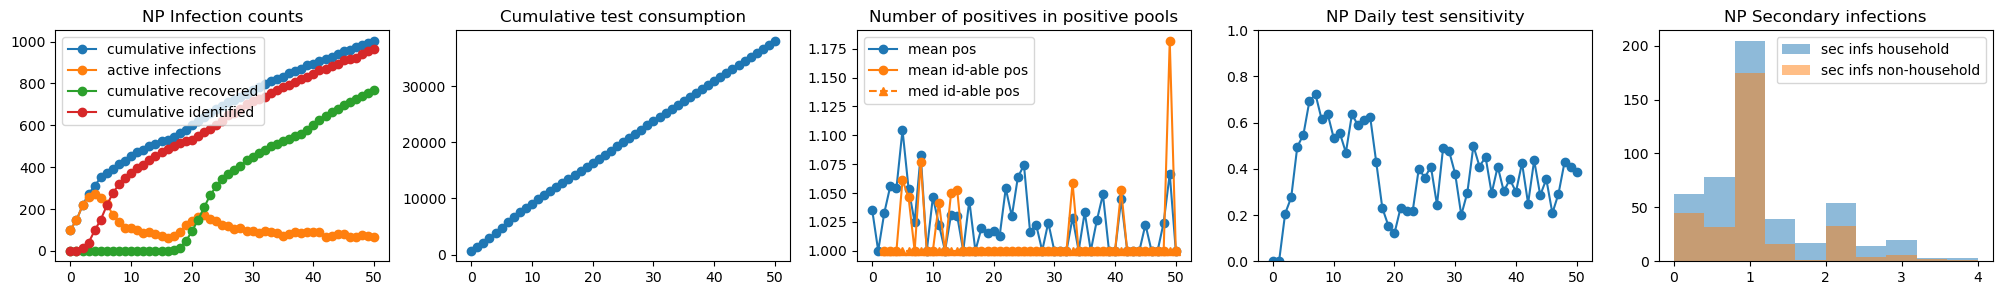

In [12]:
np_plot = plot_results(np_sim, "naive")

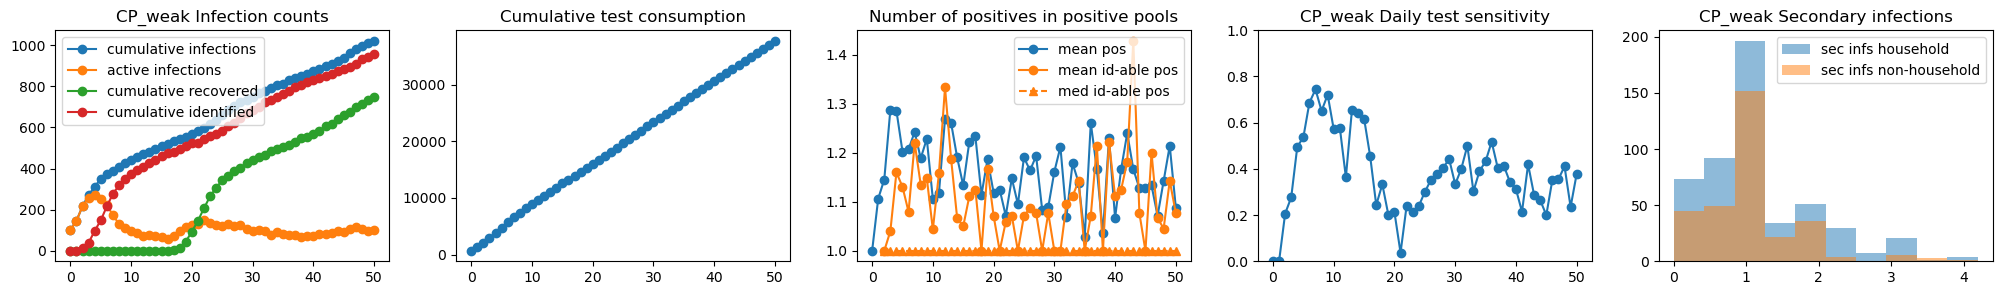

In [13]:
cp_weak_plot = plot_results(cp_weak_sim, "correlated_weak")

In [13]:
len(cp_sim.model.isolation_start_times)

5000

In [33]:
min(cp_sim.model.VL_over_time["time_points"], key=lambda x: abs(x-10))

9.992697613156514

In [37]:
cp_sim.model.VL_over_time["time_points"].index(9.992697613156514)

751

In [ ]:
cp_sim.model.VL_over_time["time_points"].index(
    min(
        cp_sim.model.VL_over_time["time_points"], 
        key=lambda x: abs(x-cp_sim.model.isolation_start_times[j])
        ))

In [34]:
values = [1,2,3,4,5]

In [36]:
values.__getitem__

<function list.__getitem__>

In [35]:
index_min = min(range(len(values)), key=values.__getitem__)
index_min

0

In [30]:
cp_sim.model.VL_over_time["VL_time_series"]

5000

In [18]:
cp_VL_at_isolation = []
np_VL_at_isolation = []
cp_isolation_time_variance = []
np_isolation_time_variance = []

i = 0
while i < len(list(cp_sim.model.households_dict.values())):
    household = list(cp_sim.model.households_dict.values())[i]
    cp_household_isolation_times = [np.round(cp_sim.model.isolation_start_times[j],2) for j in household]
    cp_household_VL_at_isolation = [
        np.round(cp_sim.model.VL_over_time["VL_time_series"][j][
            cp_sim.model.VL_over_time["time_points"].index(
                min(
                    cp_sim.model.VL_over_time["time_points"], 
                    key=lambda x: abs(x-cp_sim.model.isolation_start_times[j])
                )
            )], 2)
        for j in household
    ]
    cp_VL_at_isolation.extend(cp_household_VL_at_isolation)
    np_household_isolation_times = [np.round(np_sim.model.isolation_start_times[j],2) for j in household]
    np_household_VL_at_isolation = [
        np.round(np_sim.model.VL_over_time["VL_time_series"][j][
            np_sim.model.VL_over_time["time_points"].index(
                min(
                    np_sim.model.VL_over_time["time_points"], 
                    key=lambda x: abs(x-np_sim.model.isolation_start_times[j])
                )
            )], 2)
        for j in household
    ]
    np_VL_at_isolation.extend(np_household_VL_at_isolation)
    if any((cp_household_isolation_times[j]<100000) or (np_household_isolation_times[j]<100000) for j in range(len(household))):
        cp_isolation_time_variance.append(np.var(list(filter(lambda x: x<100000, cp_household_isolation_times))))
        np_isolation_time_variance.append(np.var(list(filter(lambda x: x<100000, np_household_isolation_times))))
        print(
            "household: ", household, 
            "\n    CP isolation time: ", cp_household_isolation_times, ", VL at isolation: ", cp_household_VL_at_isolation,
            "\n    NP isolation time: ", np_household_isolation_times, ", VL at isolation: ", np_household_VL_at_isolation,
        )
    i += len(household)

household:  [583, 3852, 3851, 3850, 3849] 
    CP isolation time:  [6.0, 6.0, 11.01, 11.01, 6.0] , VL at isolation:  [5.55, 5.68, 5.53, 5.37, 6.0] 
    NP isolation time:  [6.0, 6.0, 11.0, 100000.0, 6.0] , VL at isolation:  [5.54, 5.69, 5.54, -1.0, 6.0]
household:  [4994] 
    CP isolation time:  [100000.0] , VL at isolation:  [-1.0] 
    NP isolation time:  [42.01] , VL at isolation:  [5.15]
household:  [4993] 
    CP isolation time:  [17.0] , VL at isolation:  [5.42] 
    NP isolation time:  [100000.0] , VL at isolation:  [-1.0]
household:  [3832, 3831, 3830] 
    CP isolation time:  [24.01, 24.01, 24.01] , VL at isolation:  [5.52, 5.96, 5.72] 
    NP isolation time:  [100000.0, 100000.0, 100000.0] , VL at isolation:  [-1.0, -1.0, -1.0]
household:  [579, 3829] 
    CP isolation time:  [45.0, 45.0] , VL at isolation:  [6.0, 5.92] 
    NP isolation time:  [100000.0, 20.0] , VL at isolation:  [-1.0, 5.97]
household:  [3826, 3825, 3824, 3823] 
    CP isolation time:  [100000.0, 100000.0,

(array([995.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ,
        202.5, 225. ]),
 <BarContainer object of 10 artists>)

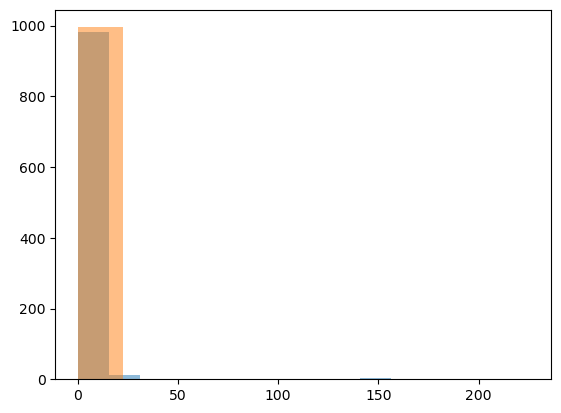

In [11]:
plt.hist(np.array(cp_isolation_time_variance)[~np.isnan(cp_isolation_time_variance)], alpha=0.5, label="CP")
plt.hist(np.array(np_isolation_time_variance)[~np.isnan(np_isolation_time_variance)], alpha=0.5, label="NP")

Text(0, 0.5, 'Density')

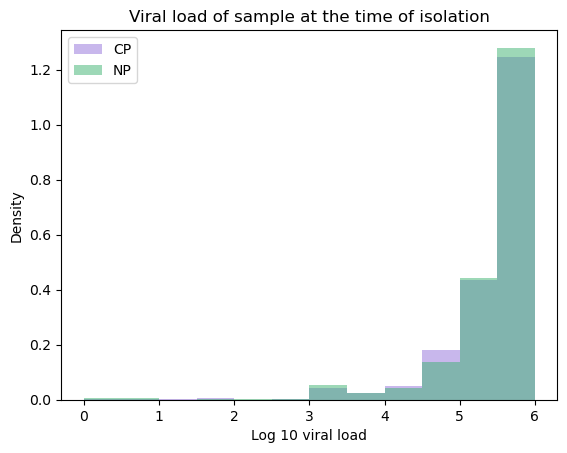

In [19]:
bins = np.linspace(0,6,13)
plt.hist(list(filter(lambda x: x>-1, cp_VL_at_isolation)), alpha=0.5, label="CP", density=True, bins=bins, color="mediumpurple")
plt.hist(list(filter(lambda x: x>-1, np_VL_at_isolation)), alpha=0.5, label="NP", density=True, bins=bins, color="mediumseagreen")
plt.legend()
plt.title("Viral load of sample at the time of isolation")
plt.xlabel("Log 10 viral load")
plt.ylabel("Density")

Generated overall age distribution:
0-9: 0.1176	(-0.0034 from target)
10-19: 0.1384	(0.0074 from target)
20-29: 0.1408	(0.0038 from target)
30-39: 0.1332	(0.0002 from target)
40-49: 0.1158	(-0.0082 from target)
50-59: 0.1288	(-0.0022 from target)
60-69: 0.1194	(0.0044 from target)
70-79: 0.0746	(0.0046 from target)
80+: 0.0314	(-0.0066 from target)

Generated household size distribution:
1: 0.2756	(-0.0081 from target)
2: 0.3536	(0.0084 from target)
3: 0.1400	(-0.0106 from target)
4: 0.1400	(0.0124 from target)
5: 0.0533	(-0.0045 from target)
6: 0.0261	(0.0035 from target)
7: 0.0113	(-0.0011 from target)
Num households: 2028
mean household size: 2.448393594

{'0-9': 588, '10-19': 692, '20-29': 704, '30-39': 666, '40-49': 579, '50-59': 644, '60-69': 597, '70-79': 373, '80+': 157}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Running simulation with seed 1 for strategy correlated_weak...
Running screening for group 0 on day 0...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


Viral loads in positive pools:  [[], [], [], [], [], [], [], []]
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Viral loads in positive pools:  [[], [], [], [], [], [], [], []]
Screening day:  1  self.model.t:  1.0000000000000007
Running screening for group 2 on day 2...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


Viral loads in positive pools:  [[], [], [], [], [], [], [], [], []]
Screening day:  2  self.model.t:  2.0000000000000013
    Nodes with transition propensities:
        node4717, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 4717 is transitioning EtoIPRE at time 2.210004320849983 with timer_state: [2.21000432]; 1/sigma: [2.20323809]; VL: 0.0
{'t': 2.210004320849983, 'transitionNode': 4717, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node2928, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 2928 is transitioning EtoIPRE at time 2.2200101095720535 with timer_state: [2.22001011]; 1/sigma: [2.21315872]; VL: 5.991448250710673
{'t': 2.2200101095720535, 'transitionNode': 2928, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.05598888992
    Nodes with transition propensities:
        node4576, in state

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Viral loads in positive pools:  [[4.291745494445998], [3.8586989817046855], [6.0], [4.183914110016636], [4.286515202745176], [5.116022910622989], [3.925970117253612], [3.7104166226640016], [5.353677595157334, 3.7414572427639823], [5.206000110549301], [4.686007154146534], [5.756203040675063]]
Screening day:  3  self.model.t:  3.0085998308729143
    Nodes with transition propensities:
        node4743, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 4743 is transitioning EtoIPRE at time 3.0286001872175836 with timer_state: [3.02860019]; 1/sigma: [3.02257179]; VL: 5.952414106501058
{'t': 3.0286001872175836, 'transitionNode': 4743, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100011.75365465393
    Nodes with transition propensities:
        node1644, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 1644 is transitioning EtoIPRE at time 3.068603814132835 with timer_state: [3.06860381]; 1/sigma: [3.06424846]; VL: 5.930

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Viral loads in positive pools:  [[5.123234686840719], [5.362484566087693], [0.1112123853729745, 6.0], [6.0], [2.1233156546423384, 0.9938520131420965], [6.0], [6.0, 2.0283035097228796], [1.6730774078193247, 1.3049616900901544], [0.4878261212062797, 0.5165721590620724, 6.0], [0.7693566100000154, 6.0], [0.19559357202642136], [6.0, 0.35075161121165727], [4.581328027120122, 4.708677505881059], [4.899193329780308]]
Screening day:  4  self.model.t:  4.001078072585032
    Nodes with transition propensities:
        node4959, in state [1], propensity [('StoE', 2.380952380952381)]
infected: 4959, transmissionTerms_I: [10.], transmissionTerms_Q: [0], household_neighbors: {3776, 3777}, non_household_neighbors: [3951]
Household member states: [array([2]), array([3])]
Non-household member states: [array([1])]
Infected node 4959 got contribution from infectious contacts {3777: 1.0} and quarantined contacts {}
{'t': 4.0129337874787305, 'transitionNode': 4959, 'transitionNodeVL': 0.0, 'transitionType':

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Viral loads in positive pools:  [[5.409403954410664], [3.2878604732080476], [2.212379798389749], [1.015669399867731], [6.0], [1.758890560821036], [2.6130625128928506], [6.0], [2.6982216711433646], [2.836093231815667, 0.5736366755083266], [6.0], [6.0], [0.6309094215571253], [1.3473170638351022], [2.145466569403655, 6.0, 0.29456015210449227], [2.5008403616586556], [2.950990803387375, 6.0], [5.961647373864712]]
Screening day:  5  self.model.t:  5.006777072948046
    Nodes with transition propensities:
        node1574, in state [1], propensity [('StoE', 1.0869565217391304)]
infected: 1574, transmissionTerms_I: [10.], transmissionTerms_Q: [0], household_neighbors: {76, 1573}, non_household_neighbors: [1856, 1793, 2629, 2054, 2183, 2887, 1545, 1353, 1362, 1555, 1620, 1623, 1368, 1820, 1638, 1511, 1323, 2489, 1389, 1790, 1519, 2545, 1970, 1587, 1977, 2366]
Household member states: [array([1]), array([3])]
Non-household member states: [array([1]), array([1]), array([1]), array([1]), array([1]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Viral loads in positive pools:  [[5.358229172005893, 3.564082779449324], [2.1103681542353527], [2.1928240935249703, 5.6525067449381385, 2.917244555026072], [4.7024200577060915], [5.619363311601962], [4.964394222401985, 5.738026993365026, 3.0679762549754406, 3.488380256640476, 5.777419631770253], [3.010445298591141, 2.929548360535337], [2.010541756198479, 1.4260533875037569], [1.7450513786287944, 1.414259138128071, 6.0], [0.2658162315898468], [5.512308644813117], [4.405383202683728, 3.338255027263016], [5.98528720099336], [4.413139132442233]]
Screening day:  6  self.model.t:  6.00230991887696
    Nodes with transition propensities:
        node1997, in state [13], propensity [('QPREtoQSYM', 100000.0)]
-- node 1997 is transitioning QPREtoQSYM at time 6.012312879176544 with timer_state: [2.45439339]; 1/lamda: [2.44993153]; VL: 6.0
{'t': 6.012312879176544, 'transitionNode': 1997, 'transitionNodeVL': 5.997185085963309, 'transitionType': 'QPREtoQSYM'}
propensity: 100000.0, sum of all propens

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Viral loads in positive pools:  [[5.723518132021851], [3.680208421007354], [0.7946518811095126], [2.1931329915108058], [5.227695414236112], [3.2038597761969942], [0.06799940244741466], [4.185982609356915, 5.622083599532629, 5.404929955018599], [6.0], [0.5454860034092391], [4.1680454273613226], [0.6678442962786573], [3.2673015429575902], [5.809693336228084], [4.097608398559949, 2.6134782900282496, 5.435605884152861], [5.805411130511636], [5.047186704144848], [3.186811770900903], [3.989867986777091], [5.12249730565448, 5.082597832257411], [6.0]]
Screening day:  7  self.model.t:  7.002926153890872
    Nodes with transition propensities:
        node1371, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 1371 is transitioning EtoIPRE at time 7.032930203969083 with timer_state: [2.89460593]; 1/sigma: [2.89427718]; VL: 5.917750868802061
{'t': 7.032930203969083, 'transitionNode': 1371, 'transitionNodeVL': 6.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Viral loads in positive pools:  [[5.733186808735368], [5.773897254241344], [3.474491978237155], [0.024900982996563223], [6.0], [5.659062638723637, 3.9376585221489124], [4.749983237505781], [4.211826122576004], [3.86313556970985], [2.8662566975267874], [3.49695654089843, 5.365019783646735, 5.8209922241494, 6.0], [5.349065957741839, 5.827102732603556, 5.650048034223382, 5.425120748667419], [5.581025980178928, 4.48277639726528], [6.0], [4.702120372958957, 4.930751205929338], [5.065866037178035], [5.995579411027833], [5.92580543203047], [5.120780904732091, 3.234875721573356, 5.563264181496198], [1.0108159569545434, 6.0, 3.2633943292168865], [1.1710799008534247], [5.334256981371335, 4.0278490437211705], [6.0, 3.7760447648528843], [5.2338241750943695], [6.0]]
Screening day:  8  self.model.t:  8.005834727503538
    Nodes with transition propensities:
        node1835, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 1835 is transitioning IPREtoISYM at time 8.015839499672675 with ti

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Viral loads in positive pools:  [[4.576555778351852, 4.702645136242375], [5.806024415093815], [4.982826308034659, 6.0], [5.235277405110887, 6.0], [5.645429414216357], [4.998424555856742, 6.0, 6.0], [5.70762764670554, 4.411977060593266], [4.637444062142043], [5.849183928501913, 6.0], [5.355273360420215], [6.0, 5.668250525048052], [6.0, 5.278650529909349], [6.0], [3.331856593035056], [6.0, 6.0], [6.0, 0.18654800725432003, 1.4695947377261611], [5.152013160154472], [4.876684816989414, 5.921347813306993]]
Screening day:  9  self.model.t:  9.00509354190576
    Nodes with transition propensities:
        node1364, in state [3], propensity [('IPREtoISYM', 100000.0)]
-- node 1364 is transitioning IPREtoISYM at time 9.01509779916308 with timer_state: [2.30224014]; 1/lamda: [2.29571232]; VL: 6.0
{'t': 9.01509779916308, 'transitionNode': 1364, 'transitionNodeVL': 5.9967237851585296, 'transitionType': 'IPREtoISYM'}
propensity: 100000.0, sum of all propensities: 100015.94781372666
    Nodes with tra

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Viral loads in positive pools:  [[6.0, 6.0], [1.200152245963912], [0.8209550780594366, 0.7645308873133682], [1.4126123777650221, 6.0], [3.757143873283107], [2.320800327643694], [6.0, 5.053803143965876, 3.6993232499674344], [5.735587219365033, 6.0, 3.9990478679304458, 5.182939818984191, 5.7591323512177], [5.585942643503452, 4.584274680374401], [1.8633339712694146, 2.6925992372976117, 0.37175996021164626], [5.427133731870439], [5.929708088421306, 5.455099376933745, 6.0], [5.904336883657817], [0.2936658099918108, 4.789088348000918, 0.02405186059982654], [5.67554696097305], [0.5257872989409722], [6.0, 2.0983503206990686]]
Screening day:  10  self.model.t:  10.00247593762701
    Nodes with transition propensities:
        node115, in state [1], propensity [('StoE', 1.282051282051282)]
infected: 115, transmissionTerms_I: [10.], transmissionTerms_Q: [0], household_neighbors: {114, 4069, 1743}, non_household_neighbors: [35, 102, 77, 53, 120, 26, 27, 317, 127]
Household member states: [array([1

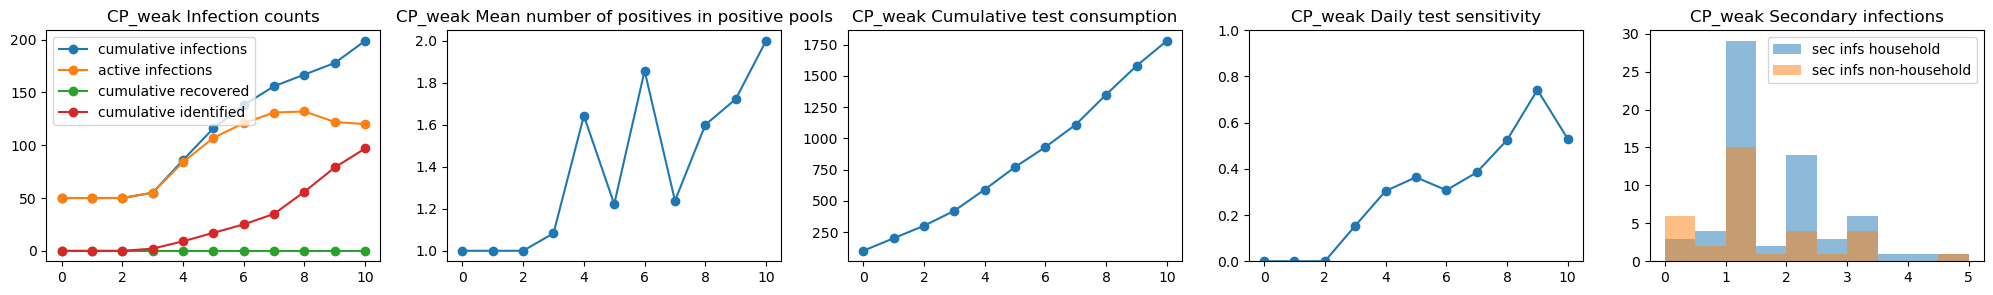

In [18]:
cpw_sim, cpw_fig = run_and_plot(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=T,
    pooling_strategy='correlated_weak',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    COMMUNITY_SIZE=COMMUNITY_SIZE,
    LoD=LoD,
    peak_VL=PEAK_VL,
    seed=SEED,
)

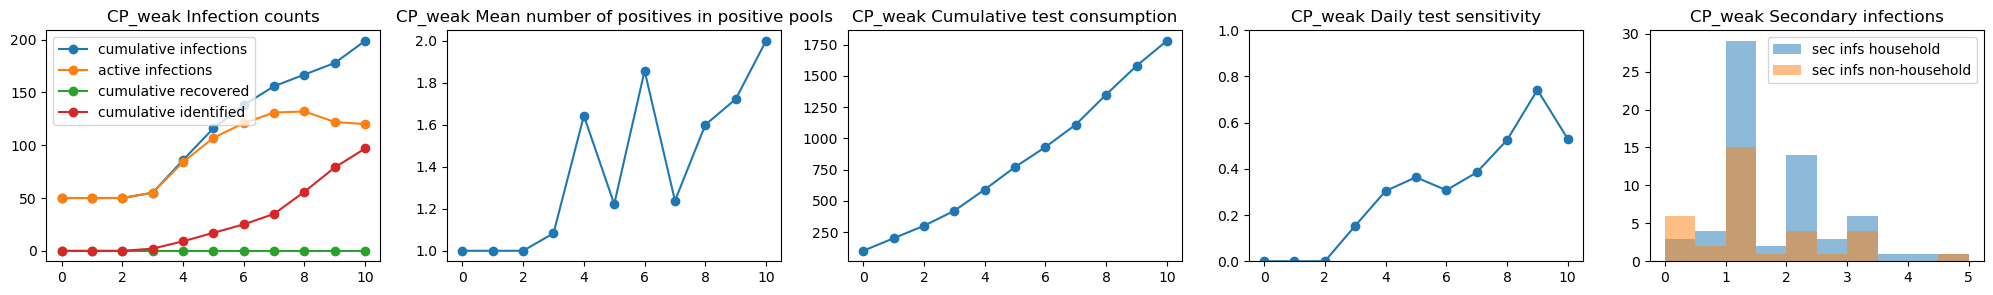

In [19]:
cpw_fig

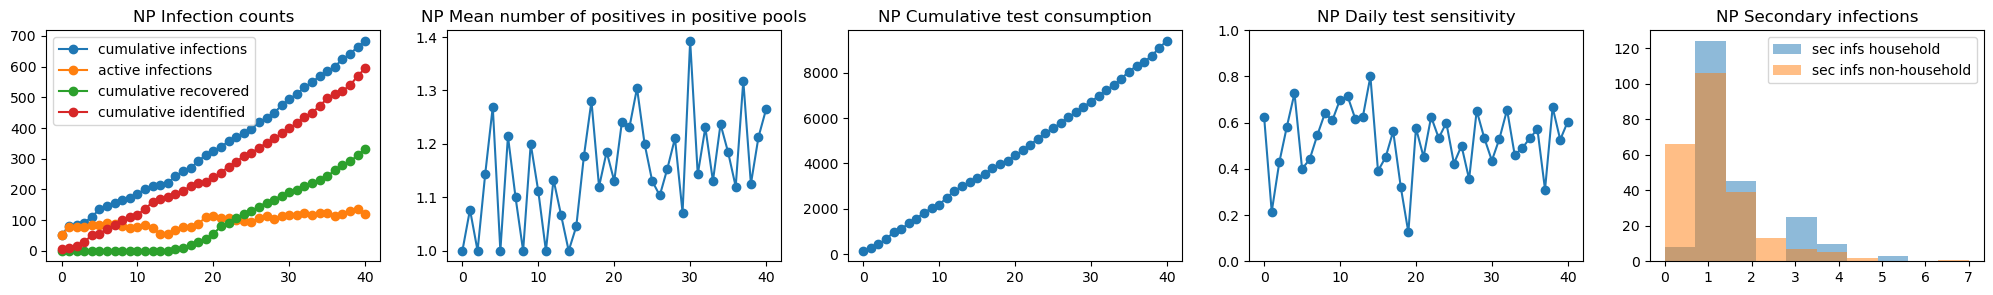

In [9]:
np_fig

Generated overall age distribution:
0-9: 0.1145	(-0.0065 from target)
10-19: 0.1285	(-0.0025 from target)
20-29: 0.1380	(0.0010 from target)
30-39: 0.1465	(0.0135 from target)
40-49: 0.1090	(-0.0150 from target)
50-59: 0.1340	(0.0030 from target)
60-69: 0.1110	(-0.0040 from target)
70-79: 0.0720	(0.0020 from target)
80+: 0.0465	(0.0085 from target)

Generated household size distribution:
1: 0.3035	(0.0198 from target)
2: 0.3378	(-0.0073 from target)
3: 0.1236	(-0.0271 from target)
4: 0.1310	(0.0033 from target)
5: 0.0624	(0.0046 from target)
6: 0.0294	(0.0068 from target)
7: 0.0122	(-0.0002 from target)
Num households: 817
mean household size: 2.448393594

{'0-9': 229, '10-19': 257, '20-29': 276, '30-39': 293, '40-49': 218, '50-59': 268, '60-69': 222, '70-79': 144, '80+': 93}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Running simulation with seed 0 for strategy naive...
Running screening for group 0 on day 0...
Viral loads in positive pools:  [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]]
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...
Viral loads in positive pools:  [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0], [-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]]
Screening day:  1  self.model.t:  1.0000000000000007
Running screening for group 2 on day 2...
Viral loads in positive pools:  [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0], [-1.0, -1.0, -1.0, -

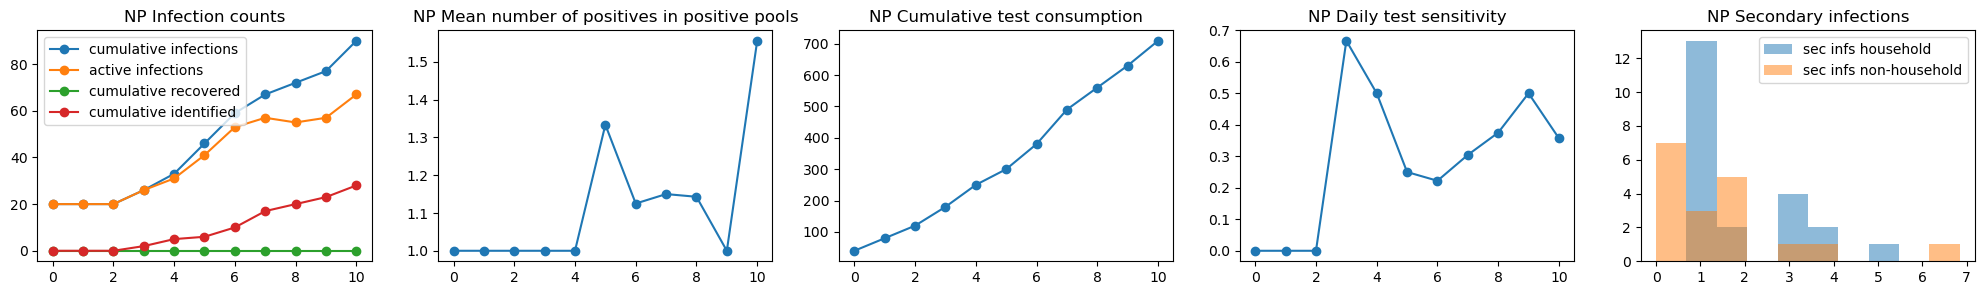

In [20]:
importlib.reload(seirsplus)

np_sim, np_fig = run_and_plot(
    N,
    "US",
    WEIGHT,
    ALPHA,
    INIT_PREV,
    T=10,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    seed=SEED,
)

(array([ 4.,  2.,  2.,  2., 54., 12., 13.,  9., 10., 16.]),
 array([0.33259514, 0.89933563, 1.46607611, 2.0328166 , 2.59955708,
        3.16629757, 3.73303806, 4.29977854, 4.86651903, 5.43325951,
        6.        ]),
 <BarContainer object of 10 artists>)

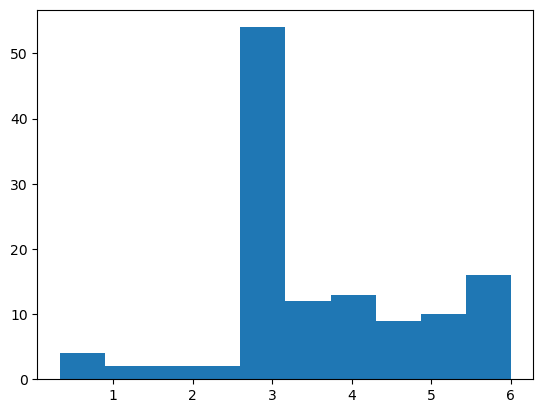

In [15]:
plt.hist([v for v in cp_sim.model.current_VL if v > 0])

In [16]:
min([0,1,2,3])

0

In [25]:
max(max(np_sim.model.sec_infs_household.values()), max(np_sim.model.sec_infs_non_household.values()))

11.976809068203297

In [30]:
sum(sim_correlated.model.degree - sim_correlated.model.degree_Q)

array([0.])

In [59]:
node=545
sim_correlated.model.transmissionTerms_Q[node], sim_correlated.model.transmissionTerms_I[node]

(array([0.]), array([40.]))

In [92]:
# np.where(not np.equal(sim_correlated.model.transmissionTerms_Q, sim_correlated.model.transmissionTerms_I))

res = [(i, (x[0],y[0])) for i, (x, y) in enumerate(zip(sim_correlated.model.transmissionTerms_Q, sim_correlated.model.transmissionTerms_I)) if x != y]
res


[(126, (0.0, 0.1)),
 (128, (0.0, 0.1)),
 (129, (0.0, 0.1)),
 (130, (0.0, 0.1)),
 (131, (0.0, 0.1)),
 (132, (0.1, 0.0)),
 (133, (0.0, 0.1)),
 (135, (0.0, 0.1)),
 (138, (0.1, 0.0)),
 (139, (0.0, 0.1)),
 (145, (0.0, 0.1)),
 (150, (0.0, 0.1)),
 (151, (0.0, 0.1)),
 (152, (0.0, 10.0)),
 (153, (0.0, 0.1)),
 (155, (0.2, 0.0)),
 (161, (0.0, 0.1)),
 (166, (0.0, 0.1)),
 (167, (0.0, 0.1)),
 (168, (0.0, 0.1)),
 (170, (0.0, 0.1)),
 (173, (0.0, 0.1)),
 (176, (0.0, 0.1)),
 (178, (0.0, 0.1)),
 (179, (0.0, 0.1)),
 (182, (0.0, 0.1)),
 (184, (0.0, 0.1)),
 (185, (0.0, 0.1)),
 (188, (0.0, 0.1)),
 (195, (10.0, 0.1)),
 (205, (0.0, 0.1)),
 (207, (0.0, 0.1)),
 (209, (0.0, 0.1)),
 (211, (0.0, 0.1)),
 (214, (0.2, 0.1)),
 (215, (0.0, 0.1)),
 (217, (0.0, 0.1)),
 (220, (0.0, 0.1)),
 (221, (0.0, 0.1)),
 (226, (0.0, 0.1)),
 (227, (0.0, 0.1)),
 (232, (0.0, 0.1)),
 (233, (0.0, 0.1)),
 (241, (0.0, 0.1)),
 (250, (0.0, 0.1)),
 (261, (0.0, 0.1)),
 (263, (0.0, 0.1)),
 (264, (0.0, 0.1)),
 (267, (0.0, 0.1)),
 (270, (0.0, 0.1))

In [60]:
sim_correlated.model.infectionsLog

[{'t': 1.288447906784009,
  'infected_node': 927,
  'infection_type': 'StoE',
  'infected_node_degree': array([54.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 1, 1, 1, 1])},
 {'t': 1.3289722093335052,
  'infected_node': 545,
  'infection_type': 'StoE',
  'infected_node_degree': array([56.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 1, 1, 1, 2])},
 {'t': 1.6479340654636487,
  'infected_node': 546,
  'infection_type': 'StoE',
  'infected_node_degree': array([57.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 1, 1, 2, 2])},
 {'t': 1.8334123874999255,
  'infected_node': 925,
  'infection_type': 'StoE',
  'infected_node_degree': array([52.]),
  'household_members': [927, 926, 925, 547, 546, 545],
  'household_members_states': array([2, 3, 2, 1, 2, 2])},
 {'t': 3.408402162224979,
  'infected_node': 547,
  'infection_type': 'St

In [54]:
sum(sim_correlated.model.beta_local - sim_correlated.model.beta_Q_local)

array([0.])

In [32]:
sim_correlated.model.sec_infs_non_household

defaultdict(int,
            {840: 2.0,
             926: 1.0,
             776: 1.2,
             830: 1.2,
             831: 0.20990099009900992,
             789: 0.2,
             828: 0.2})

In [33]:
sim_correlated.model.sec_infs_household

defaultdict(int,
            {926: 5.0,
             840: 1.0,
             887: 2.0,
             830: 3.0,
             789: 2.99009900990099,
             863: 1.0})

In [110]:
len(sim_correlated.model.infectionsLog)

6

In [120]:
sum(sim_correlated.model.sec_infs_non_household.values()) + sum(sim_correlated.model.sec_infs_household.values())

143.00000000000003

In [27]:
sim_correlated.model.households_dict[927]

{545, 546, 547, 925, 926}

In [28]:
set(list(sim_correlated.model.G._adj[927].keys())) - set(sim_correlated.model.households_dict[927])

{778, 801, 808, 809}

Text(0.5, 1.0, '# susceptible neighbors')

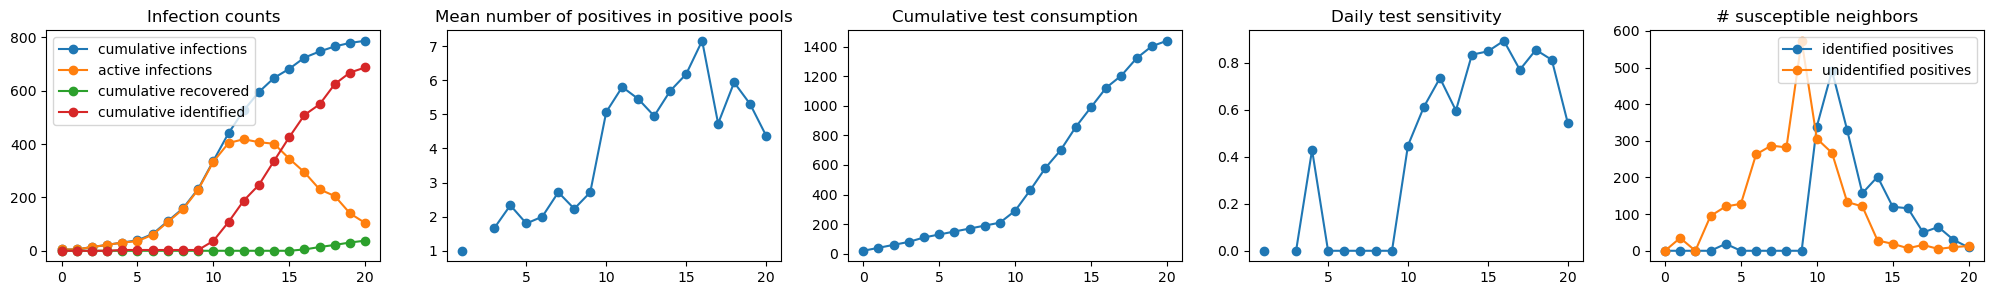

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

sim = sim_correlated

axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors")

In [ ]:
# get infection start times of members of infected households 

for household in households:
    if not all(sim_correlated.model.infection_start_times[node_id] == 1e5 for node_id in household["indices"]):
        print("Household: ", household['indices'])
        print([(node_id, sim_correlated.model.infection_start_times[node_id]) for node_id in household["indices"]])



In [ ]:
# can confirm that they are infected aroud the same time

## Naive pooling

In [24]:

random.seed(SEED)
np.random.seed(SEED)

from seirsplus.networks import generate_demographic_contact_network, household_country_data

demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=N, demographic_data=household_country_data('US'), 
                                                            distancing_scales=[0.7], isolation_groups=[])

G = demographic_graphs['baseline']

G_weighted = copy.deepcopy(G)

for e in G.edges():
    if "weight" not in G[e[0]][e[1]]:
        G[e[0]][e[1]]["weight"] = WEIGHT

for e in G_weighted.edges():
    if "weight" not in G_weighted[e[0]][e[1]]:
        G_weighted[e[0]][e[1]]["weight"] = 10**10


households_dict = {}
for household in households:
    for node_id in household["indices"]:
        households_dict[node_id] = household["indices"]
               
sim_naive = run_sim(
    G,
    G_weighted,
    households_dict,
    ALPHA,
    N,
    INIT_PREV,
    T=20,
    pooling_strategy='naive',
    NUM_SCREENING_GROUPS=NUM_SCREENING_GROUPS,
    POOL_SIZE=POOL_SIZE,
    LoD=LoD,
    seed=SEED,
)


Generated overall age distribution:
0-9: 0.1360	(0.0150 from target)
10-19: 0.1340	(0.0030 from target)
20-29: 0.1420	(0.0050 from target)
30-39: 0.1370	(0.0040 from target)
40-49: 0.1190	(-0.0050 from target)
50-59: 0.1390	(0.0080 from target)
60-69: 0.1000	(-0.0150 from target)
70-79: 0.0500	(-0.0200 from target)
80+: 0.0430	(0.0050 from target)

Generated household size distribution:
1: 0.3230	(0.0393 from target)
2: 0.3587	(0.0136 from target)
3: 0.1140	(-0.0367 from target)
4: 0.1045	(-0.0231 from target)
5: 0.0451	(-0.0126 from target)
6: 0.0333	(0.0106 from target)
7: 0.0214	(0.0089 from target)
Num households: 421
mean household size: 2.448393594

{'0-9': 136, '10-19': 134, '20-29': 142, '30-39': 137, '40-49': 119, '50-59': 139, '60-69': 100, '70-79': 50, '80+': 43}
Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Running simulation with seed 2 for strategy naive...
Running screening for group 0 on day 0...
Viral loads in positive pools:  []
Screening day:  0  self.model.t:  0.01
Running screening for group 1 on day 1...
Viral loads in positive pools:  []
Screening day:  1  self.model.t:  1.0000000000000007
    Nodes with transition propensities:
        node61, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 61 is transitioning EtoIPRE at time 1.0000014764313119 with timer_state: [1.00000148]; 1/sigma: [1.]; VL: 0.0
{'t': 1.0000014764313119, 'transitionNode': 61, 'transitionNodeVL': 4.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 500000.0
    Nodes with transition propensities:
        node311, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 311 is transitioning EtoIPRE at time 1.0000015211666329 with timer_state: [1.00000152]; 1/sigma: [1.]; VL: 4.0
{'t': 1.0000015211666329, 'transitionNode': 311, 'transitionNodeVL': 4.0, 'transitionType': 'Et

Text(0.5, 1.0, '# susceptible neighbors')

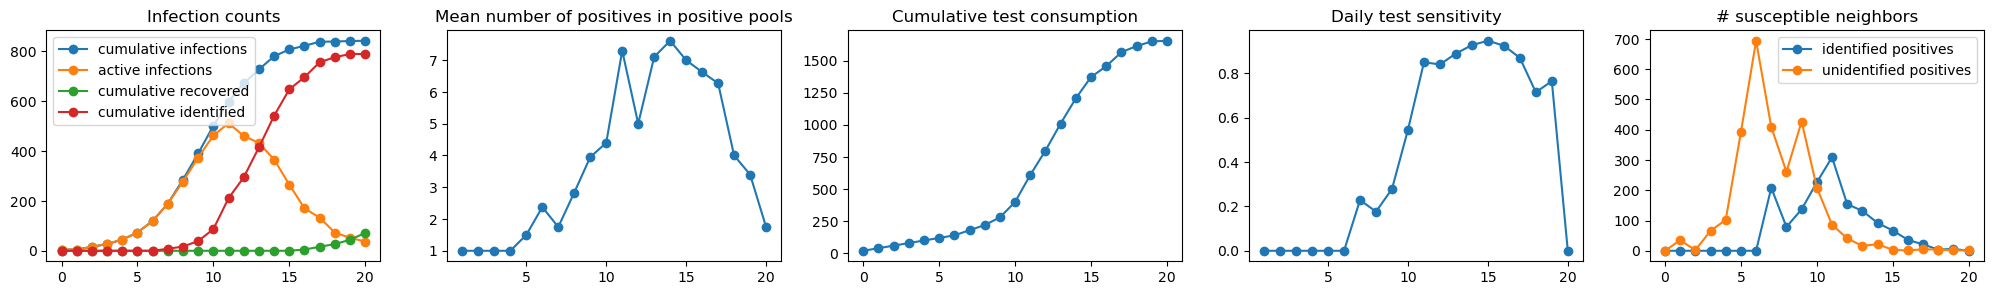

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

sim = sim_naive

axs[0].plot([sim.overall_results[i]["cumInfections"] for i in range(len(sim.overall_results))], "-o", label="cumulative infections")
axs[0].plot([sim.overall_results[i]["numActiveInfections"] for i in range(len(sim.overall_results))], "-o", label="active infections")
axs[0].plot([sim.overall_results[i]["cumRecovered"] for i in range(len(sim.overall_results))], "-o", label="cumulative recovered")
axs[0].plot([sim.overall_results[i]["cum_positives_identified"] for i in range(len(sim.overall_results))], "-o", label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim.overall_results))], "-o", label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim.overall_results[i]["cum_num_tests"] for i in range(len(sim.overall_results))], "-o", label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim.overall_results[i]["daily_sensitivity"] for i in range(len(sim.overall_results))], "-o", label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim.overall_results))], "-o", label="identified positives")
axs[4].plot([sim.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim.overall_results))], "-o", label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors")

# below old

In [21]:
random.seed(0)
np.random.seed(0)

N = 2000
INIT_EXPOSED = int(N*0.002)

from seirsplus.networks import generate_demographic_contact_network, household_country_data

demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=N, demographic_data=household_country_data('test10'),
                                                            layer_generator = "LFR", 
                                                            distancing_scales=[0.7], isolation_groups=[])

G = demographic_graphs['baseline']
# assign higher weights to inter-household edges
for e in G.edges():
    if "weight" not in G[e[0]][e[1]]:
        G[e[0]][e[1]]["weight"] = WEIGHT

households_dict = {}
for household in households:
    for node_id in household["indices"]:
        households_dict[node_id] = household["indices"]


"""
0-9: 0.1145	(-0.0065 from target)
10-19: 0.1285	(-0.0025 from target)
20-29: 0.1380	(0.0010 from target)
30-39: 0.1465	(0.0135 from target)
40-49: 0.1090	(-0.0150 from target)
50-59: 0.1340	(0.0030 from target)
60-69: 0.1110	(-0.0040 from target)
70-79: 0.0720	(0.0020 from target)
80+: 0.0465	(0.0085 from target)

Generated household size distribution:
1: 0.3035	(0.0198 from target)
2: 0.3378	(-0.0073 from target)
3: 0.1236	(-0.0271 from target)
4: 0.1310	(0.0033 from target)
5: 0.0624	(0.0046 from target)
6: 0.0294	(0.0068 from target)
7: 0.0122	(-0.0002 from target)
Num households: 817
mean household size: 2.448393594
"""

householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u20_NOTo60_eq1': 0, 'NOTu20_o60_eq1': 0.0011, 'NOTu20_NOTo60_eq1': 0.0089, 'u20_o60_gt1': 0.0341, 'u20_NOTo60_gt1': 0.30269999999999997, 'NOTu20_o60_gt1': 0.3449, 'NOTu20_NOTo60_gt1': 0.3083}
householdSituations_prob: {'u20_o60_eq1': 0, 'u2

KeyboardInterrupt: 

In [6]:
from seirsplus.viral_model import ViralExtSEIRNetworkModel
from seirsplus.sim_loops_pooled_test import SimulationRunner

test_model = ViralExtSEIRNetworkModel(
    G = G,
    households_dict=households_dict,
    beta = 0.1,
    # beta_Q = 0,
    sigma = 0.2,
    lamda = 0.5,
    gamma  = 0.25,
    seed = 0,
    alpha = ALPHA,
    initE = INIT_EXPOSED,
    transition_mode = "time_in_state",
    verbose=1,
    )

sim_naive = SimulationRunner(
    model = test_model,
    pooling_strategy='naive',
    T = 10,
    # num_groups = 10,
    num_groups = NUM_SCREENING_GROUPS,
    pool_size = POOL_SIZE,
    # LoD=500,
    LoD=LoD,
    seed = 0,
    # output_path = "home/yz685/corr_pooling_seirsplus/results/test",
    save_results = False,
    max_dt=0.01
)

sim_naive.run_simulation()

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]
/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yz685/corr_pooling_seirsplus/seirsplus/models.py:2344: RuntimeWarning: divide by zero encountered in divide
  propensities_ISYMtoH     = 1e5 * ((self.X==self.I_sym) & numpy.greater(self.timer_state, 1/self.eta) & numpy.less(self.rand_h, self.h))
/home/yz685/corr_pooling_seirsplus/seirsplus/models.py:2350: RuntimeWarning: divide by zero encountered in divide
  propensities_HtoF        = 1e5 * ((self.X==self.H) & numpy.greater(self.timer_state, 1/self.mu_H) & numpy.less(self.rand_f, self.f))
/home/yz685/corr_pooling_seirsplus/seirsplus/models.py:2370: RuntimeWarning: divide by zero encountered in divide
  propensities_QSYMtoH     = 1e5 * ((self.X==sel

    Nodes with transition propensities:
        node275, in state [2], propensity [('EtoIPRE', 100000.0)]
-- node 275 is transitioning EtoIPRE at time 1.0000006414993063 with timer_state: [1.00000064]; 1/sigma: [1.]; VL: 0.0
{'t': 1.0000006414993063, 'transitionNode': 275, 'transitionNodeVL': 4.0, 'transitionType': 'EtoIPRE'}
propensity: 100000.0, sum of all propensities: 100000.0
    Nodes with transition propensities:
        node454, in state [1], propensity [('StoE', 2.2727272727272725)]
infected: 454, transmissionTerms_I: [10.], transmissionTerms_Q: [0.], household_neighbors: {274, 275, 276, 453}, non_household_neighbors: [424, 408, 403, 400]
Household member states: [array([1]), array([3]), array([1]), array([1])]
Non-household member states: [array([1]), array([1]), array([1]), array([1])]
Infected node 454 got contribution from infectious contacts {275: 1.0} and quarantined contacts {}
{'t': 1.0545625279706978, 'transitionNode': 454, 'transitionNodeVL': 0.0, 'transitionType': '

In [113]:
len(sim_naive.model.infectionsLog)

8

In [77]:
# sum(sim_naive.model.A_Q_deltabeta_Q.toarray() - sim_correlated.model.A_Q_deltabeta_Q.toarray())
sum(sim_naive.model.A_deltabeta.toarray() - sim_correlated.model.A_deltabeta.toarray()).sum()

0.0

(array([994.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

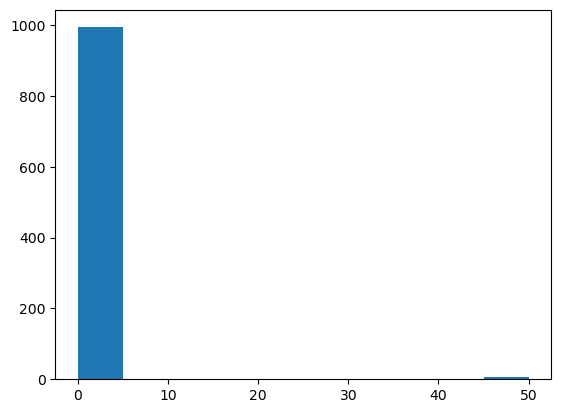

In [71]:
# if you don't set beta_Q=0, it's by default beta, 
# but then transmissionTerms_Q is different from transmissionTerms_I
plt.hist(sim_naive.model.transmissionTerms_Q - sim_naive.model.transmissionTerms_I)

/home/yz685/anaconda3/envs/corr_pooling/lib/python3.11/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, '# susceptible neighbors of identified positives')

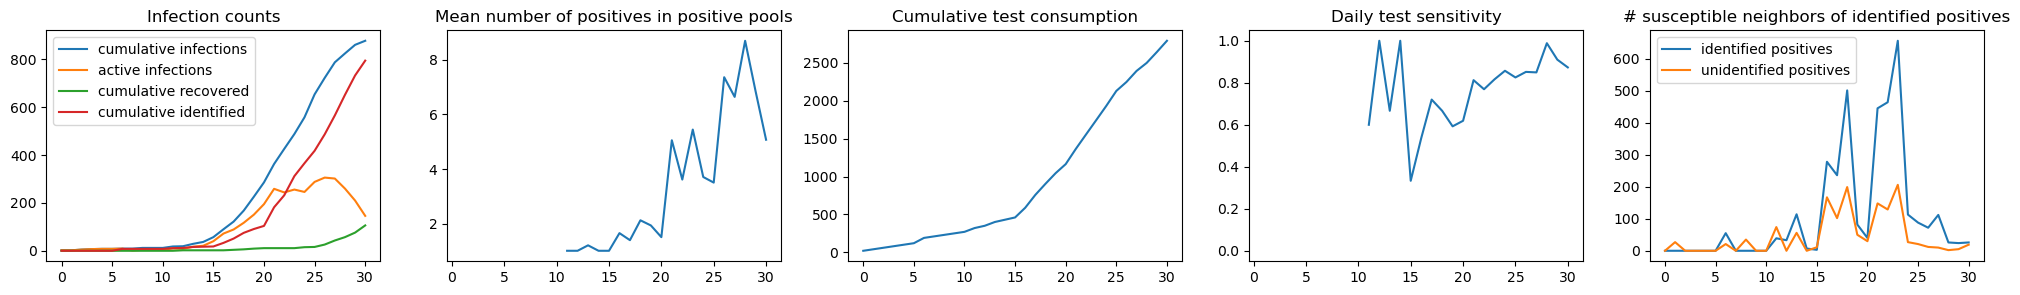

In [138]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

axs[0].plot([sim_naive.overall_results[i]["cumInfections"] for i in range(len(sim_naive.overall_results))], label="cumulative infections")
axs[0].plot([sim_naive.overall_results[i]["numActiveInfections"] for i in range(len(sim_naive.overall_results))], label="active infections")
axs[0].plot([sim_naive.overall_results[i]["cumRecovered"] for i in range(len(sim_naive.overall_results))], label="cumulative recovered")
axs[0].plot([sim_naive.overall_results[i]["cum_positives_identified"] for i in range(len(sim_naive.overall_results))], label="cumulative identified")
axs[0].legend()
axs[0].set_title("Infection counts")

axs[1].plot([sim_naive.overall_results[i]["mean_num_positives_in_positive_pool"] for i in range(len(sim_naive.overall_results))], label="mean_num_positives_in_positive_pool")
axs[1].set_title("Mean number of positives in positive pools")

axs[2].plot([sim_naive.overall_results[i]["cum_num_tests"] for i in range(len(sim_naive.overall_results))], label="cum_num_tests")
axs[2].set_title("Cumulative test consumption")

axs[3].plot([sim_naive.overall_results[i]["daily_sensitivity"] for i in range(len(sim_naive.overall_results))], label="daily_sensitivity")
axs[3].set_title("Daily test sensitivity")

axs[4].plot([sim_naive.overall_results[i]["num_susceptible_neighbors_of_identified_positives"] for i in range(len(sim_naive.overall_results))], label="identified positives")
axs[4].plot([sim_naive.overall_results[i]["num_susceptible_neighbors_of_unidentified_positives"] for i in range(len(sim_naive.overall_results))], label="unidentified positives")
axs[4].legend()
axs[4].set_title("# susceptible neighbors of identified positives")

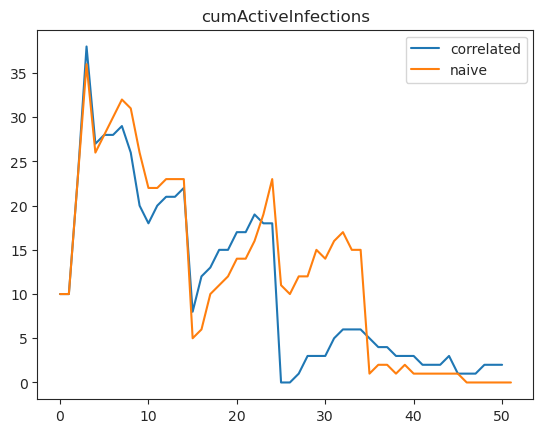

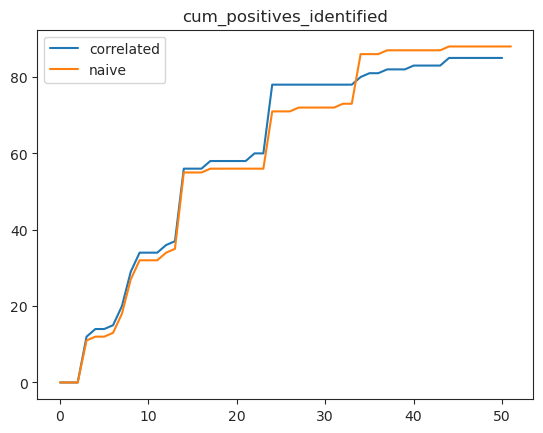

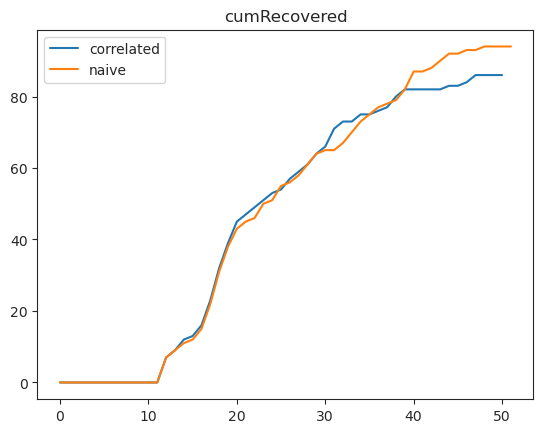

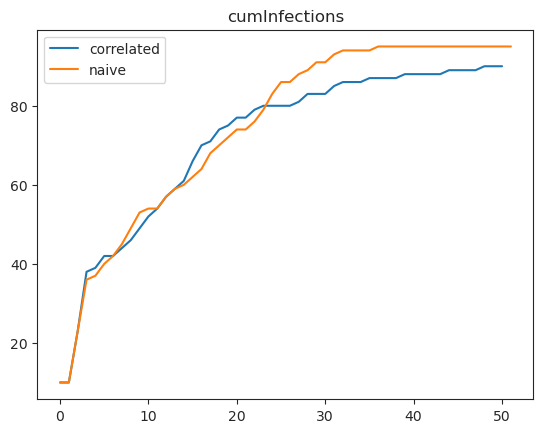

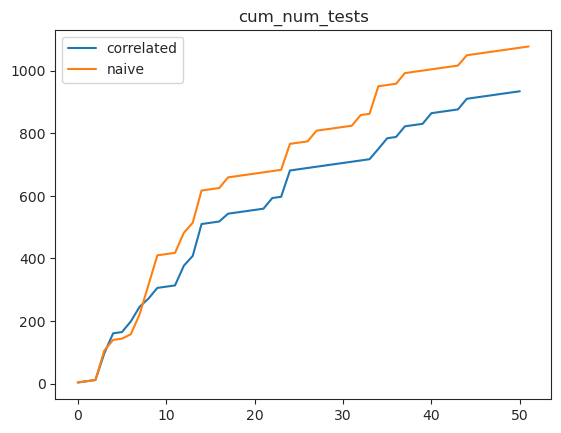

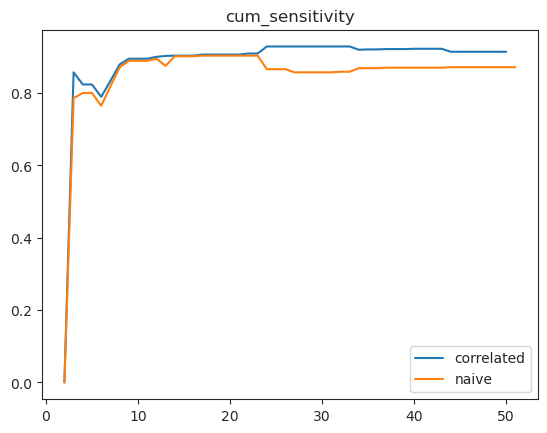

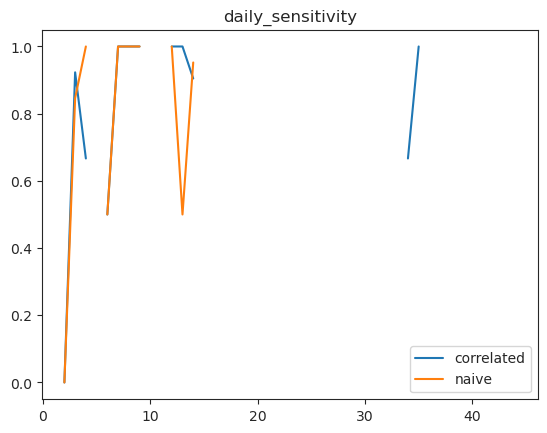

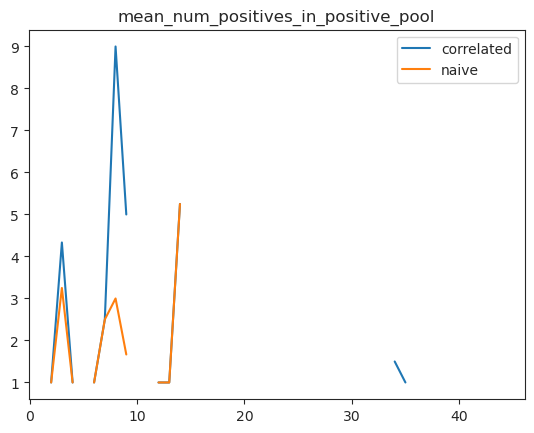

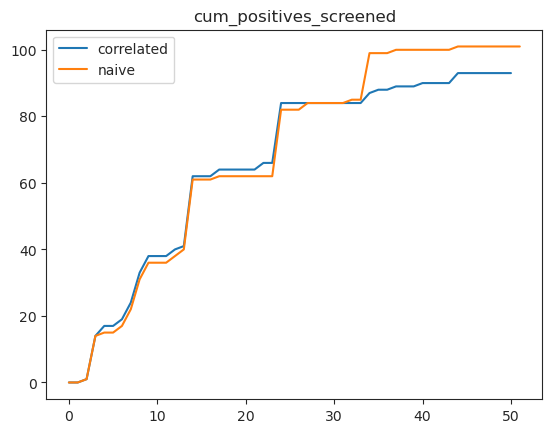

In [16]:
for metric in metrics:
    plt.plot([result[metric] for result in sim_correlated.overall_results])
    plt.plot([result[metric] for result in sim_naive.overall_results])
    plt.title(metric)
    plt.legend(['correlated', 'naive'])
    plt.show()